In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw
from seabird.cnv import fCNV
import pandas as pd

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))



mbathy[mbathy>32] = 32

In [21]:
sal_week = sal[112:123,:,:,:]
temp_week = temp[112:123,:,:,:]
spic_week = spic[112:123,:,:,:]
rho_week = spic[112:123,:,:,:]

sal_mean = np.mean(sal_week, axis=0)
temp_mean = np.mean(temp_week, axis=0)
spic_mean = np.mean(spic_week, axis=0)
rho_mean  = np.mean(rho_week, axis=0)


In [82]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


lon = bathy['nav_lon'][180:350, 480:650]
lat = bathy['nav_lat'][180:350, 480:650]

lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]

y = np.empty_like(lat_location)
x = np.empty_like(lat_location)


for i in np.arange(lat_location.shape[0]):
    y[i], x[i] = geo_tools.find_closest_model_point(
               lon_location[i],lat_location[i],lon_model,lat_model,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
n = np.empty_like(lat_location)
m = np.empty_like(lat_location)


for i in np.arange(lat_location.shape[0]):
    n[i], m[i] = geo_tools.find_closest_model_point(
               lon_location[i],lat_location[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

y = y.astype(int)
x = x.astype(int)

n = n.astype(int)
m = m.astype(int)

cmap = plt.get_cmap('Blues_r')

cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=500)

ax.scatter(x[:], y[:], c='orangered', s=100, alpha=0.6, label = 'Closest Falkor Points')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)

ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
ax.grid()


In [23]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,1:,1:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,1:,1:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [24]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    

In [25]:
u_week = u_vel[112:123,:,:,:]
v_week = v_vel[112:123,:,:,:]


u_mean = np.mean(u_week, axis=0)
v_mean = np.mean(v_week, axis=0)



In [26]:
# u_vel = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_U_20130817-20130826.nc').variables['uo']#[:,:,1:,1:]
# v_vel = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_V_20130817-20130826.nc').variables['vo']#[:,:,1:,1:]

# u_mean = np.mean(u_vel, axis=0)
# v_mean = np.mean(v_vel, axis=0)

In [37]:
def plot_spic_subplot(level, ax, cmin, cmax):
    
    import matplotlib as mpl
    norm = mpl.colors.Normalize(vmin=cmin,vmax=-cmax)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']

    y_wcvi_slice = np.array(np.arange(180,350))
    x_wcvi_slice = np.array(np.arange(480,650))

    arrow_step = 7
    y_slice_a = y_wcvi_slice[::arrow_step]
    x_slice_a = x_wcvi_slice[::arrow_step]



    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]

    y = np.empty_like(lat_location)
    x = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon_model,lat_model,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

    n = np.empty_like(lat_location)
    m = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        n[i], m[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    spic_tzyx = spic_mean[level,...]
    spic_tzyx = np.ma.masked_array(spic_tzyx, mask= 1- tmask[level,...])

#     tra_tzyx = tracer_mean[level,...]
#     tra_tzyx = np.ma.masked_array(tra_tzyx, mask= 1- tmask[level,...])


    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice, spic_tzyx, cmap=cmap, norm = norm, vmin = cmin, vmax = cmax)

    value = zlevels[level]
    tol = 0.5
    for file_number in np.arange(len(file)):
        for i in np.arange(z_location[file_number].shape[0]):
            idx = (z_location[file_number][i] <= value+tol ) & (z_location[file_number][i] >= value-tol)
            if idx == True:
                spic_falkor_depth = spic_falk_loc[file_number][i]
                ax.scatter(x[file_number], y[file_number], c = spic_falkor_depth, norm = norm, cmap = cmap, vmin = cmin, vmax= cmax, s=500, alpha=0.5)#, label = 'Closest Falkor Points')


    u_tzyx, v_tzyx = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])
    u_tzyx = np.ma.masked_array(u_tzyx, mask= 1- umask[level,1:,1:,])
    v_tzyx = np.ma.masked_array(v_tzyx, mask= 1- vmask[level,1:,1:])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[::arrow_step,::arrow_step], v_tzyx[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005)
    ax.set_xlabel('x Index',fontsize=18)
    ax.set_ylabel('y Index',fontsize=18)


    ax.set_title('depth \u2248 {d:.2f} m'.format(d=zlevels[level], z=zlevels),fontsize=18)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
    ax.grid()
    return ax, mesh

def plot_temp_subplot(level, ax, cmin, cmax):
    
    import matplotlib as mpl
    norm = mpl.colors.Normalize(vmin=cmin,vmax=-cmax)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']

    y_wcvi_slice = np.array(np.arange(180,350))
    x_wcvi_slice = np.array(np.arange(480,650))

    arrow_step = 7
    y_slice_a = y_wcvi_slice[::arrow_step]
    x_slice_a = x_wcvi_slice[::arrow_step]



    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]

    y = np.empty_like(lat_location)
    x = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon_model,lat_model,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

    n = np.empty_like(lat_location)
    m = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        n[i], m[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})



    temp_tzyx = temp_mean[level,...]
    temp_tzyx = np.ma.masked_array(temp_tzyx, mask= 1- tmask[level,...])



    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice, temp_tzyx, cmap=cmap, norm = norm, vmin = cmin, vmax = cmax)

    value = zlevels[level]
    tol = 0.5
    for file_number in np.arange(len(file)):
        for i in np.arange(z_location[file_number].shape[0]):
            idx = (z_location[file_number][i] <= value+tol ) & (z_location[file_number][i] >= value-tol)
            if idx == True:
                temp_falkor_depth = temp_location[file_number][i]
                ax.scatter(x[file_number], y[file_number], c = temp_falkor_depth, norm = norm, cmap = cmap, vmin = cmin, vmax= cmax, s=500, alpha=0.5)#, label = 'Closest Falkor Points')


    u_tzyx, v_tzyx = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])
    u_tzyx = np.ma.masked_array(u_tzyx, mask= 1- umask[level,1:,1:,])
    v_tzyx = np.ma.masked_array(v_tzyx, mask= 1- vmask[level,1:,1:])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[::arrow_step,::arrow_step], v_tzyx[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005)
    ax.set_xlabel('x Index',fontsize=18)
    ax.set_ylabel('y Index',fontsize=18)


    ax.set_title('depth \u2248 {d:.2f} m'.format(d=zlevels[level], z=zlevels),fontsize=18)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
    ax.grid()
    return ax, mesh


def plot_sal_subplot(level, ax, cmin, cmax):
    
    import matplotlib as mpl
    norm = mpl.colors.Normalize(vmin=cmin,vmax=-cmax)

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']

    y_wcvi_slice = np.array(np.arange(180,350))
    x_wcvi_slice = np.array(np.arange(480,650))

    arrow_step = 7
    y_slice_a = y_wcvi_slice[::arrow_step]
    x_slice_a = x_wcvi_slice[::arrow_step]



    lon = bathy['nav_lon'][180:350, 480:650]
    lat = bathy['nav_lat'][180:350, 480:650]

    lon_model = bathy['nav_lon'][...]
    lat_model = bathy['nav_lat'][...]

    y = np.empty_like(lat_location)
    x = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon_model,lat_model,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

    n = np.empty_like(lat_location)
    m = np.empty_like(lat_location)


    for i in np.arange(lat_location.shape[0]):
        n[i], m[i] = geo_tools.find_closest_model_point(
                   lon_location[i],lat_location[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})



    sal_tzyx = sal_mean[level,...]
    sal_tzyx = np.ma.masked_array(sal_tzyx, mask= 1- tmask[level,...])



    viz_tools.set_aspect(ax)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice, sal_tzyx, cmap=cmap, norm = norm, vmin = cmin, vmax = cmax)

    value = zlevels[level]
    tol = 0.5
    for file_number in np.arange(len(file)):
        for i in np.arange(z_location[file_number].shape[0]):
            idx = (z_location[file_number][i] <= value+tol ) & (z_location[file_number][i] >= value-tol)
            if idx == True:
                sal_falkor_depth = sal_location[file_number][i]
                ax.scatter(x[file_number], y[file_number], c = sal_falkor_depth, norm = norm, cmap = cmap, vmin = cmin, vmax= cmax, s=500, alpha=0.5)#, label = 'Closest Falkor Points')


    u_tzyx, v_tzyx = viz_tools.unstagger(u_mean[level,...], v_mean[level,...])
    u_tzyx = np.ma.masked_array(u_tzyx, mask= 1- umask[level,1:,1:,])
    v_tzyx = np.ma.masked_array(v_tzyx, mask= 1- vmask[level,1:,1:])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[::arrow_step,::arrow_step], v_tzyx[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', cmap=cmap, width=0.005)
    ax.set_xlabel('x Index',fontsize=18)
    ax.set_ylabel('y Index',fontsize=18)


    ax.set_title('depth \u2248 {d:.2f} m'.format(d=zlevels[level], z=zlevels),fontsize=18)
    legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
    ax.grid()
    return ax, mesh







/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


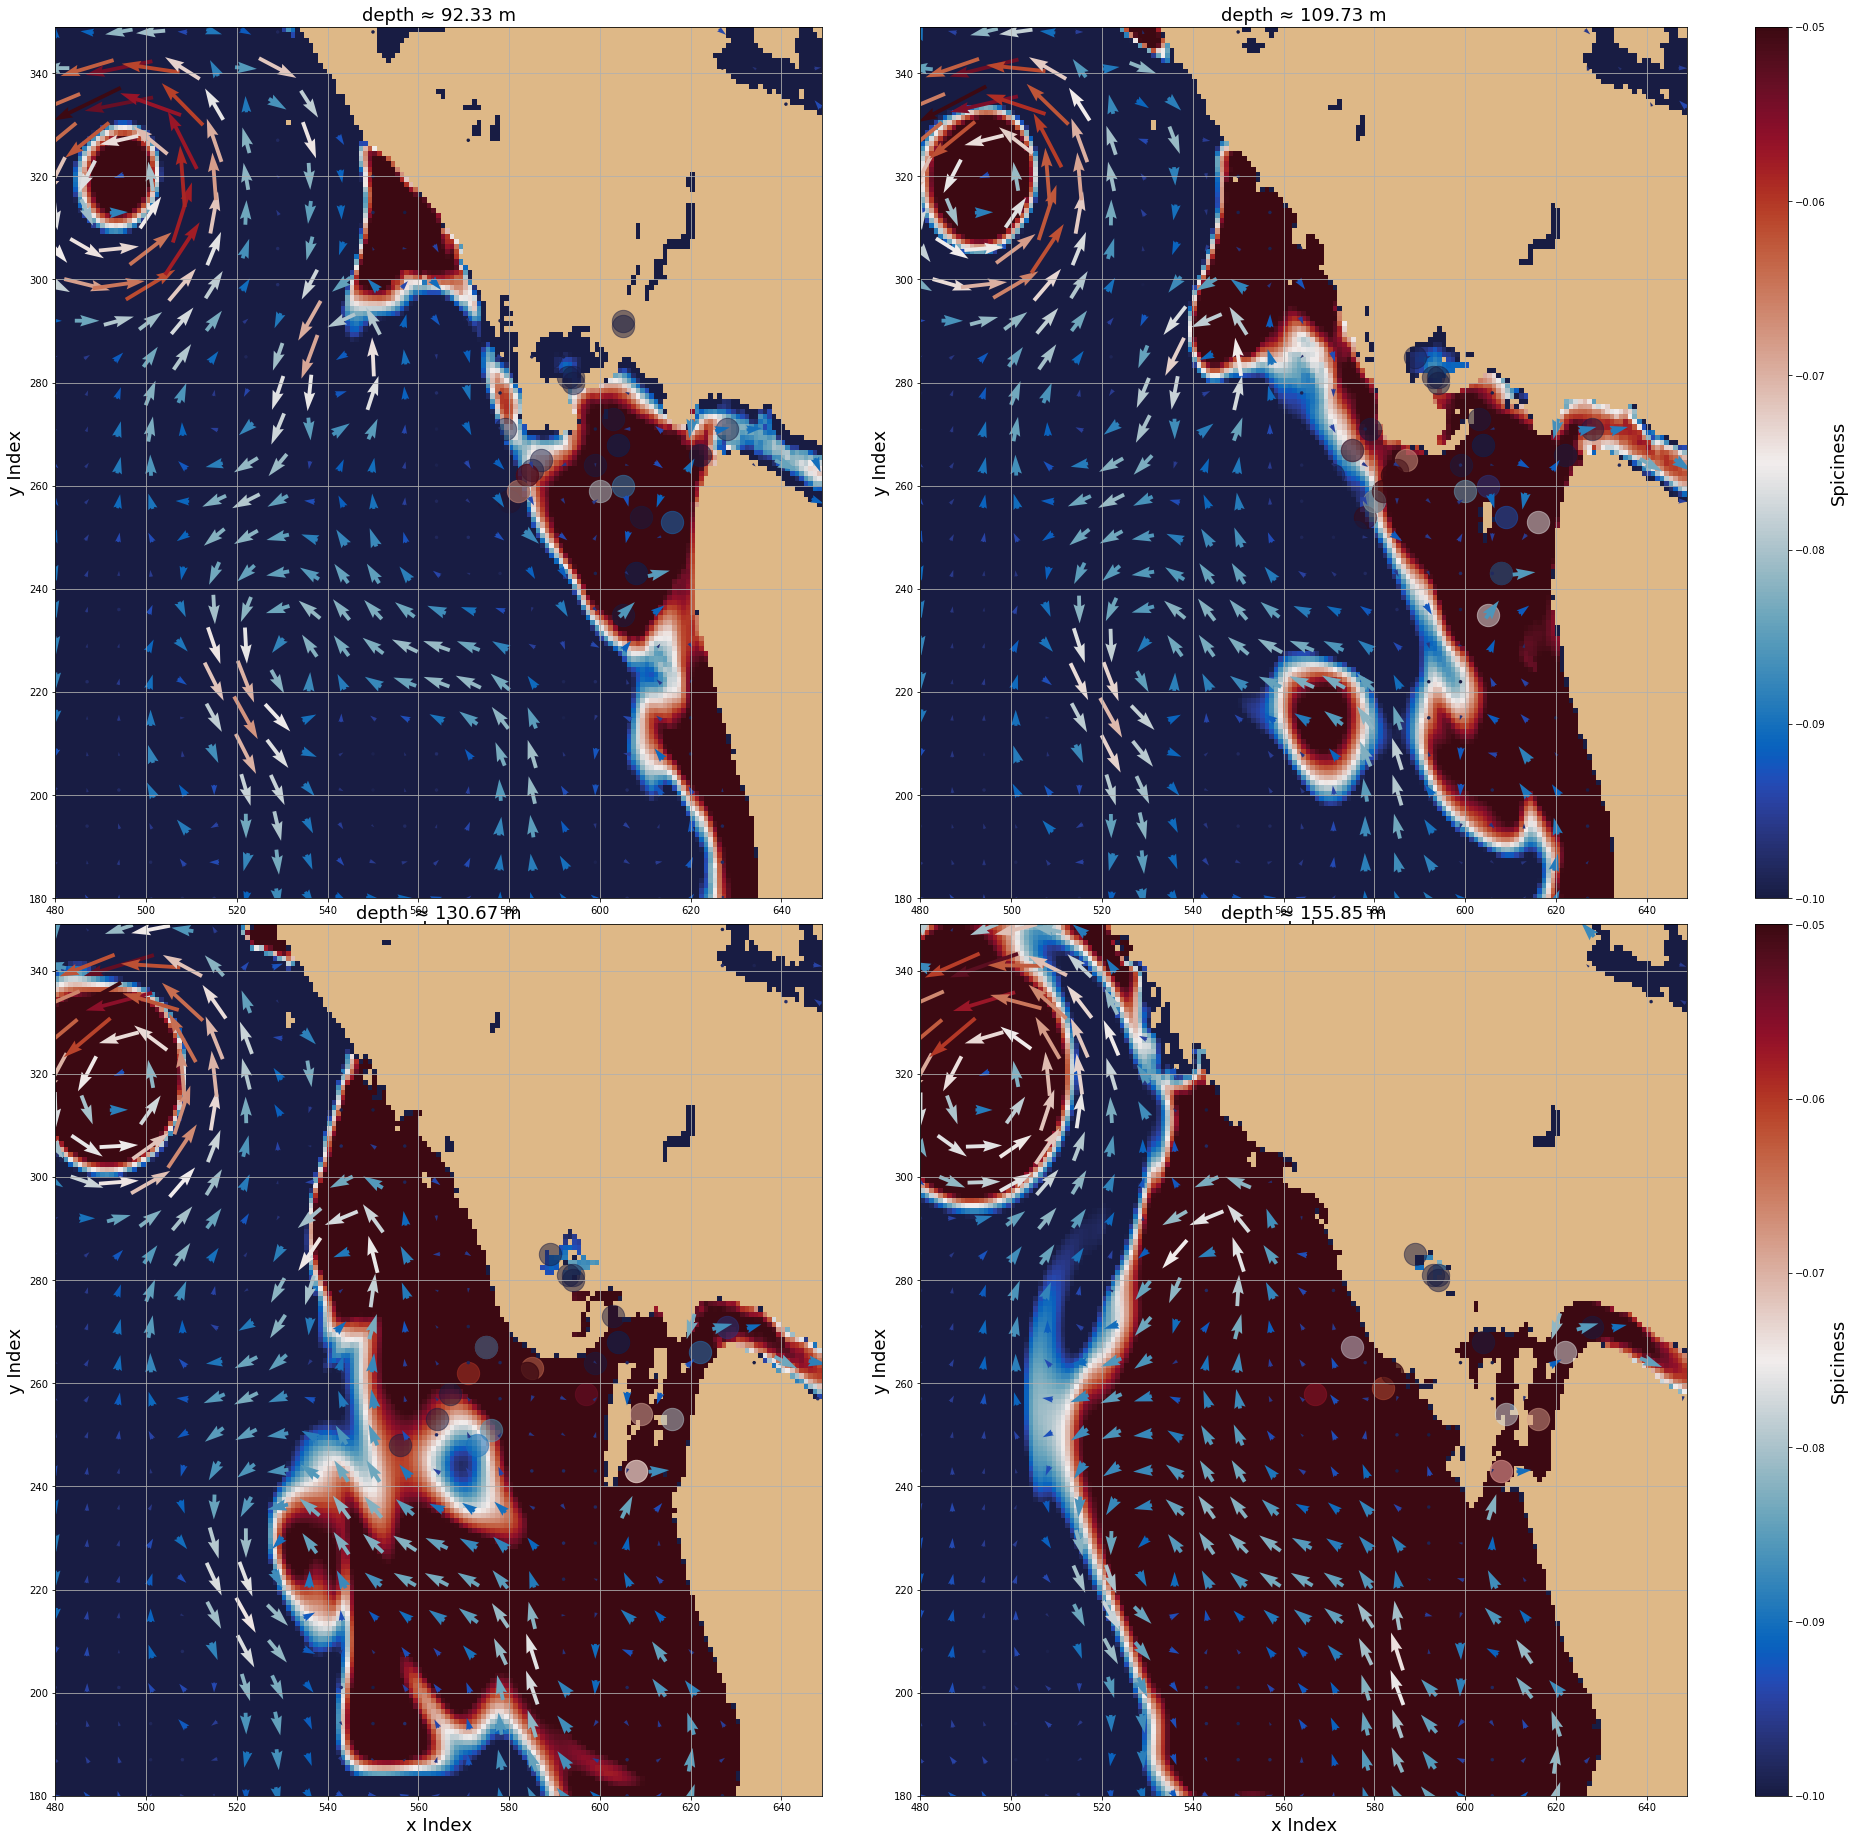

In [38]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_spic_subplot(level= 21, ax= axs[0,0], cmin = -0.1, cmax = -0.05)
axs[0,1], mesh = plot_spic_subplot(level= 22, ax= axs[0,1], cmin = -0.1, cmax = -0.05)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label='Spiciness', fontsize = 18)

axs[1,0], mesh = plot_spic_subplot(level= 23, ax= axs[1,0], cmin = -0.1, cmax = -0.05)
axs[1,1], mesh = plot_spic_subplot(level= 24, ax= axs[1,1], cmin = -0.1, cmax = -0.05)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label='Spiciness', fontsize = 18)

In [39]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_spic_subplot(level= 24, ax= axs[0,0], cmin = -0.1, cmax = -0.05)
axs[0,1], mesh = plot_spic_subplot(level= 25, ax= axs[0,1], cmin = -0.1, cmax = -0.05)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label='Spiciness', fontsize = 18)

axs[1,0], mesh = plot_spic_subplot(level= 26, ax= axs[1,0], cmin = -0.1, cmax = -0.05)
axs[1,1], mesh = plot_spic_subplot(level= 27, ax= axs[1,1], cmin = -0.1, cmax = -0.05)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label='Spiciness', fontsize = 18)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [40]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_temp_subplot(level= 21, ax= axs[0,0], cmin = 7, cmax = 8)
axs[0,1], mesh = plot_temp_subplot(level= 22, ax= axs[0,1], cmin = 7, cmax = 8)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label = 'Temperature', fontsize = 18)

axs[1,0], mesh = plot_temp_subplot(level= 23, ax= axs[1,0], cmin = 7, cmax = 8)
axs[1,1], mesh = plot_temp_subplot(level= 24, ax= axs[1,1], cmin = 7, cmax = 8)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label = 'Temperature', fontsize = 18)


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [41]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_temp_subplot(level= 24, ax= axs[0,0], cmin = 7, cmax = 8)
axs[0,1], mesh = plot_temp_subplot(level= 25, ax= axs[0,1], cmin = 7, cmax = 8)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label = 'Temperature', fontsize = 18)

axs[1,0], mesh = plot_temp_subplot(level= 26, ax= axs[1,0], cmin = 7, cmax = 8)
axs[1,1], mesh = plot_temp_subplot(level= 27, ax= axs[1,1], cmin = 7, cmax = 8)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label = 'Temperature', fontsize = 18)


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


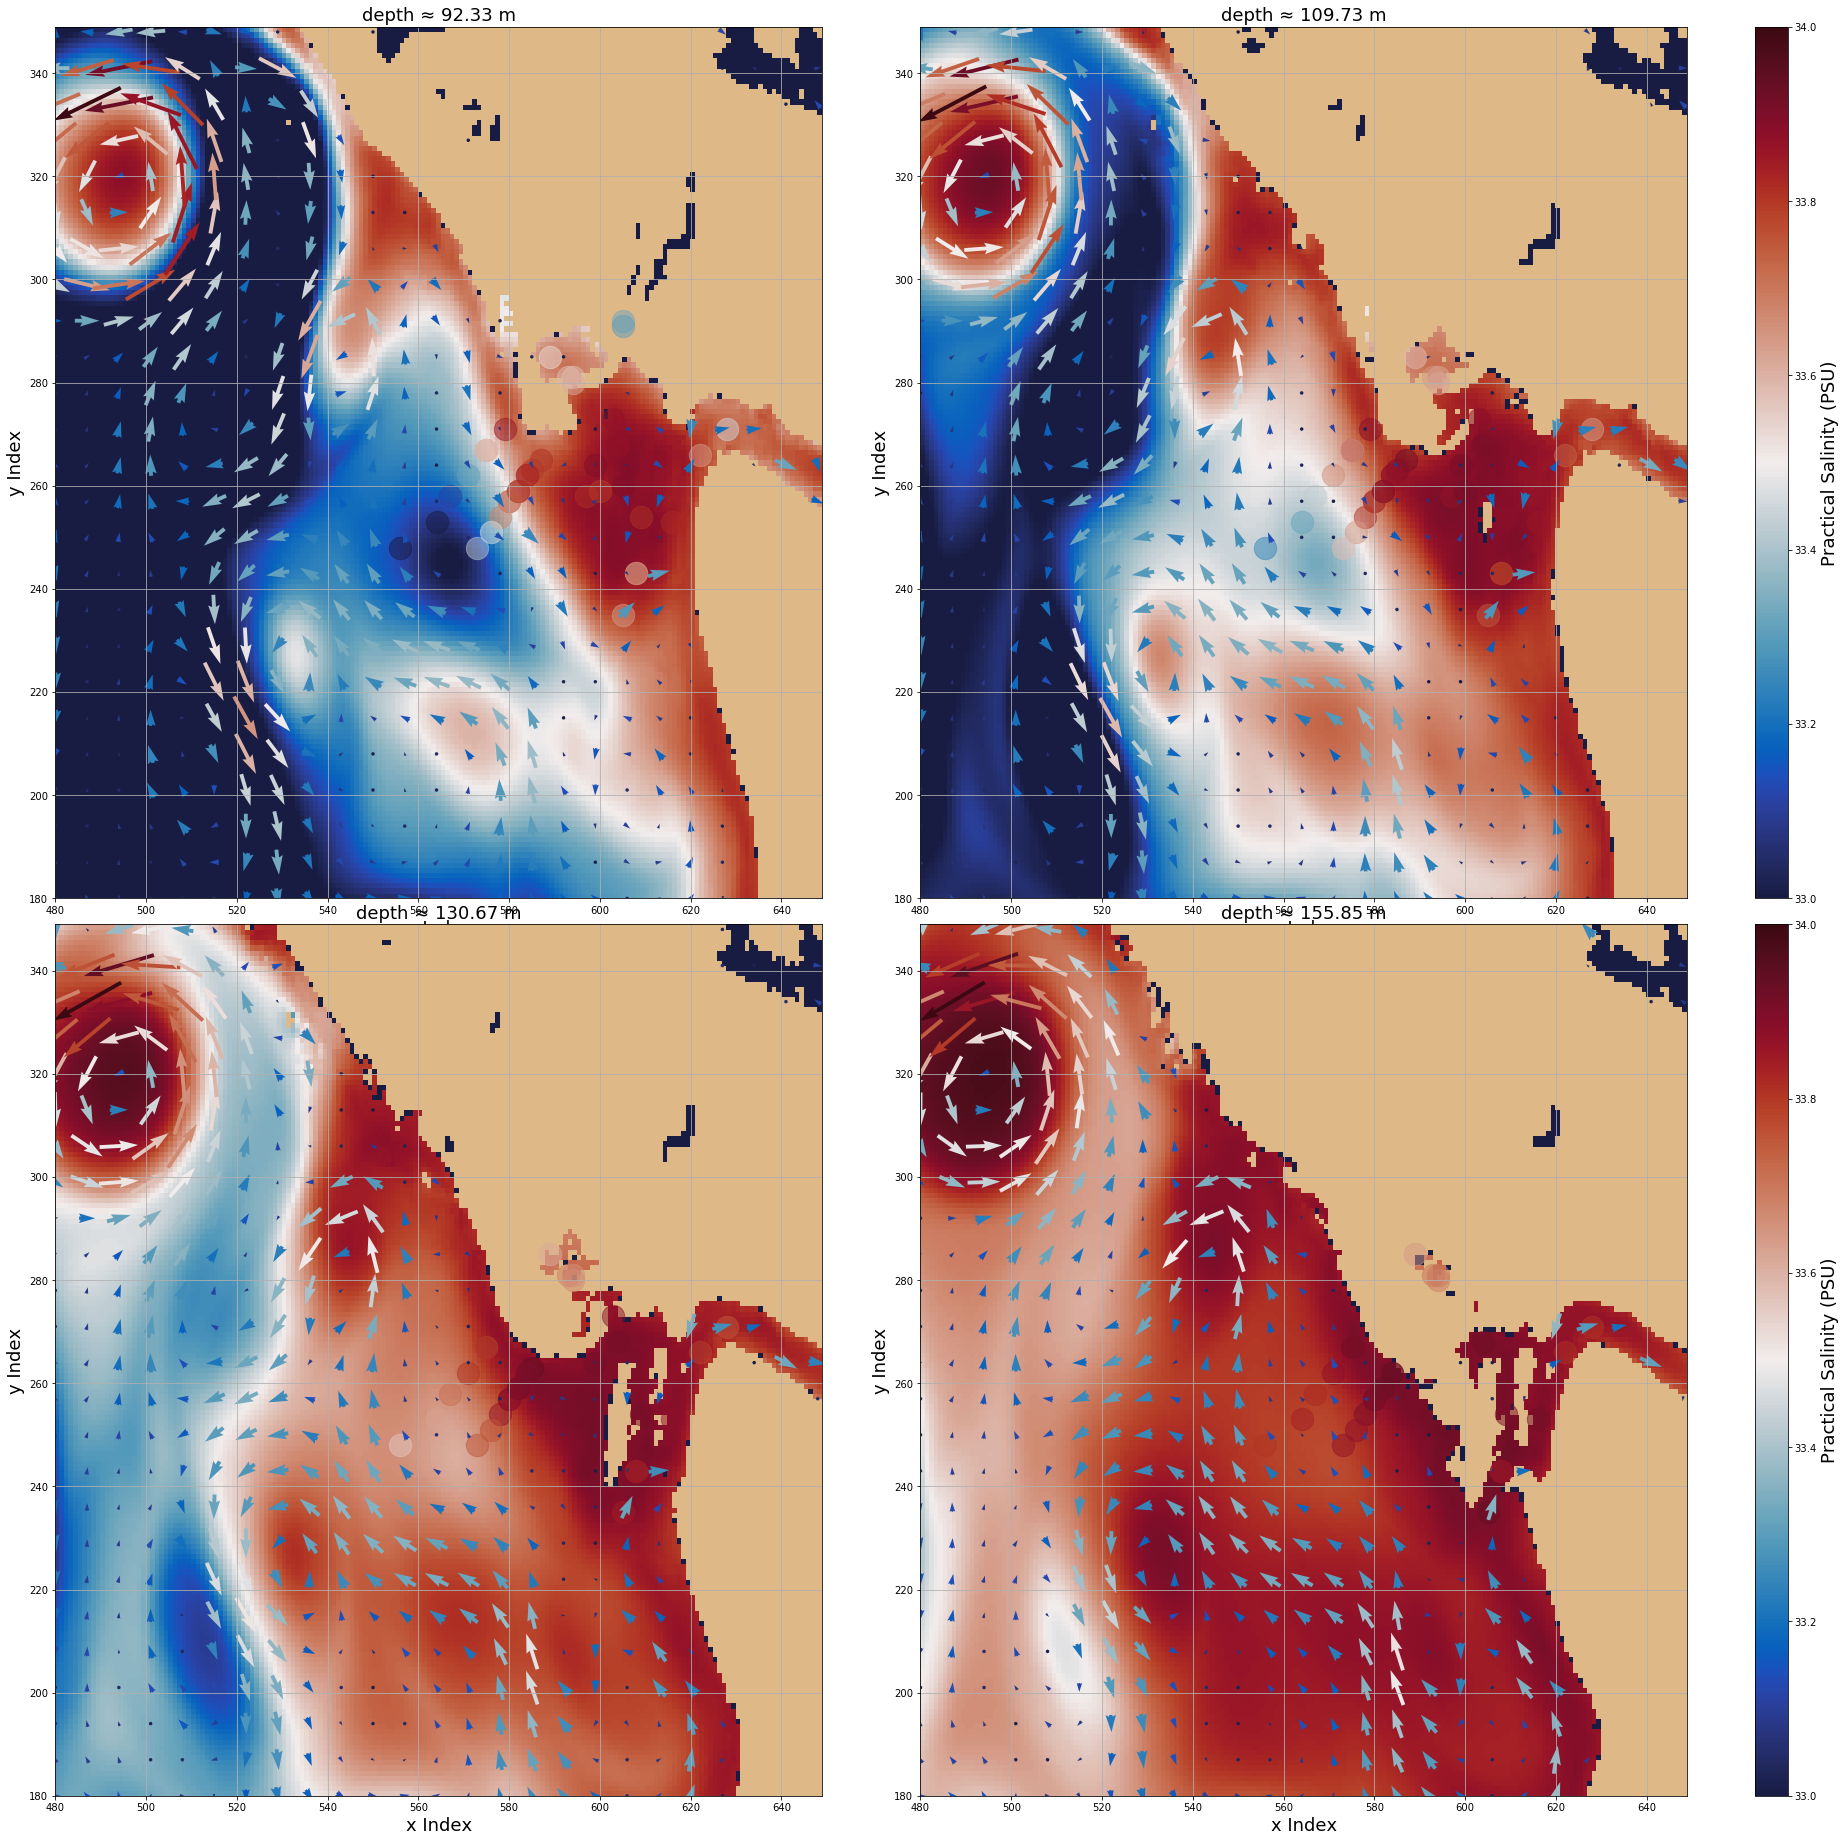

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_sal_subplot(level= 21, ax= axs[0,0], cmin = 33, cmax = 34)
axs[0,1], mesh = plot_sal_subplot(level= 22, ax= axs[0,1], cmin = 33, cmax = 34)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label = 'Practical Salinity (PSU)', fontsize = 18)

axs[1,0], mesh = plot_sal_subplot(level= 23, ax= axs[1,0], cmin = 33, cmax = 34)
axs[1,1], mesh = plot_sal_subplot(level= 24, ax= axs[1,1], cmin = 33, cmax = 34)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label = 'Practical Salinity (PSU)', fontsize = 18)


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


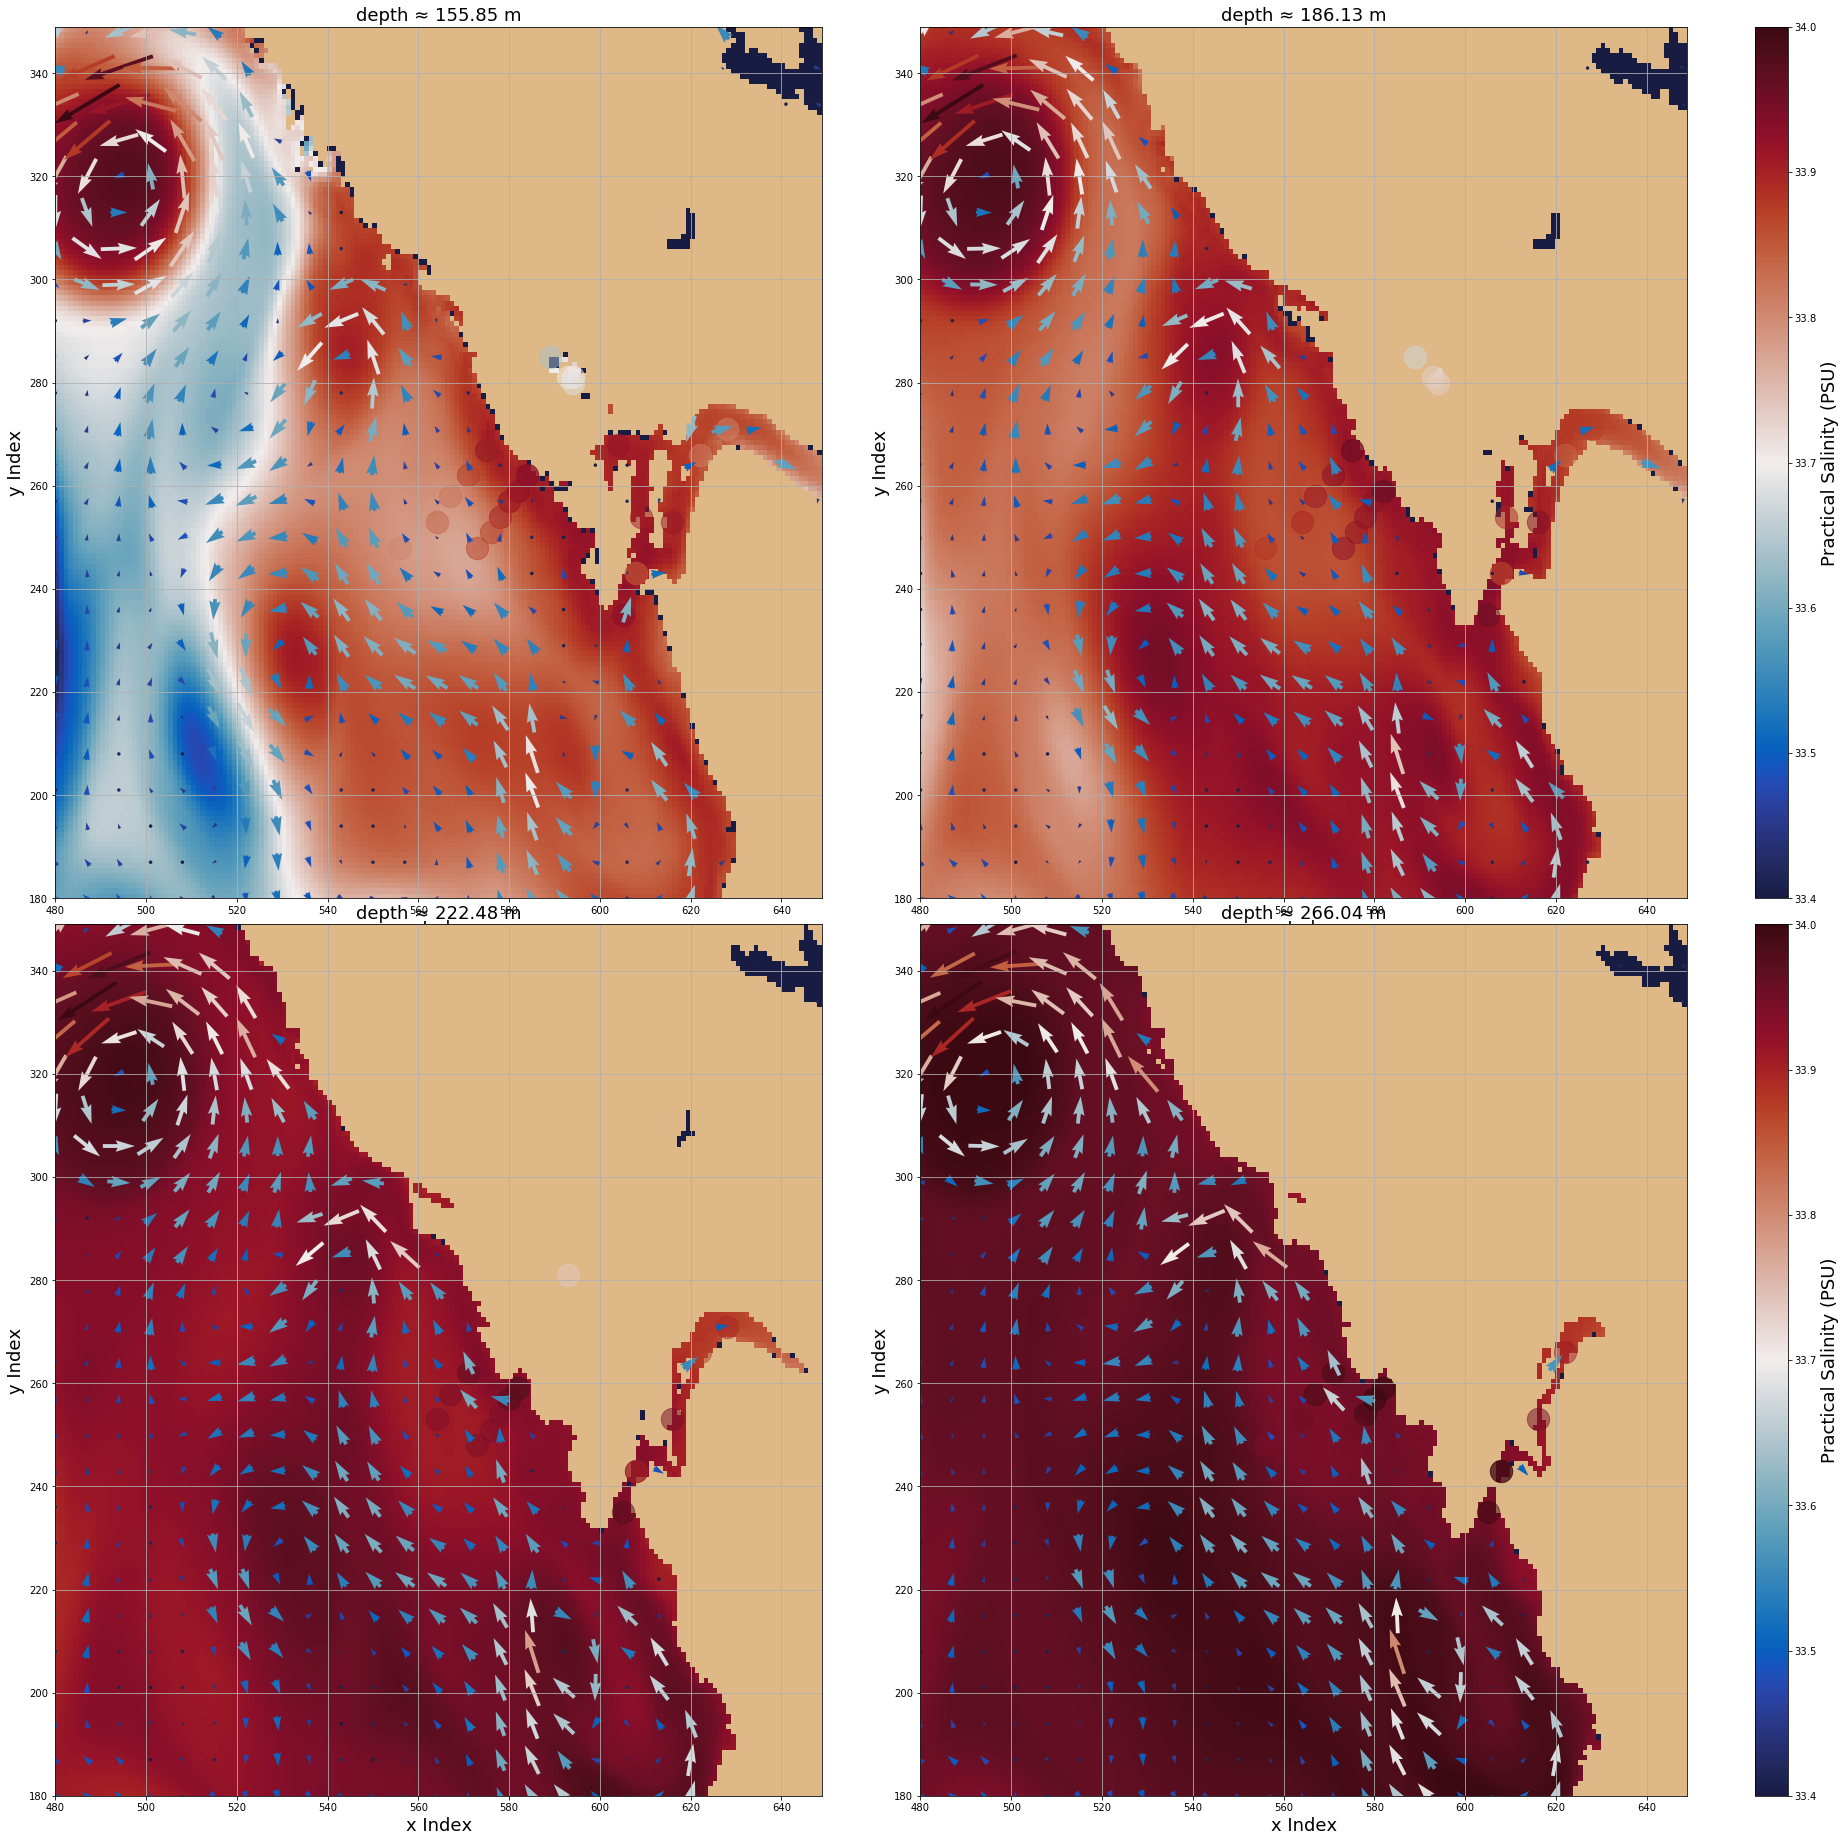

In [43]:
fig, axs = plt.subplots(2, 3, figsize=(25, 25), gridspec_kw={'width_ratios': [25, 25, 1]})

fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)

axs[0,0], mesh = plot_sal_subplot(level= 24, ax= axs[0,0], cmin = 33.4, cmax = 34)
axs[0,1], mesh = plot_sal_subplot(level= 25, ax= axs[0,1], cmin = 33.4, cmax = 34)

cbar = fig.colorbar(mesh, cax=axs[0,2])
cbar.set_label(label = 'Practical Salinity (PSU)', fontsize = 18)

axs[1,0], mesh = plot_sal_subplot(level= 26, ax= axs[1,0], cmin = 33.4, cmax = 34)
axs[1,1], mesh = plot_sal_subplot(level= 27, ax= axs[1,1], cmin = 33.4, cmax = 34)

cbar = plt.colorbar(mesh, cax=axs[1,2])
cbar.set_label(label = 'Practical Salinity (PSU)', fontsize = 18)


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


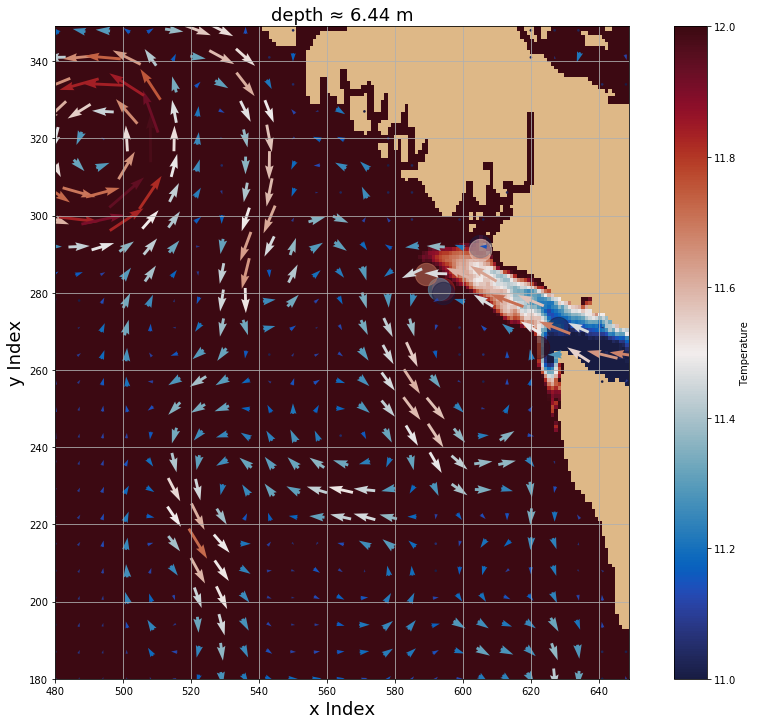

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(16,12))

axs, mesh = plot_temp_subplot(level= 5, ax= axs, cmin = 11, cmax = 12)
cbar = fig.colorbar(mesh, ax=axs, label='Temperature')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


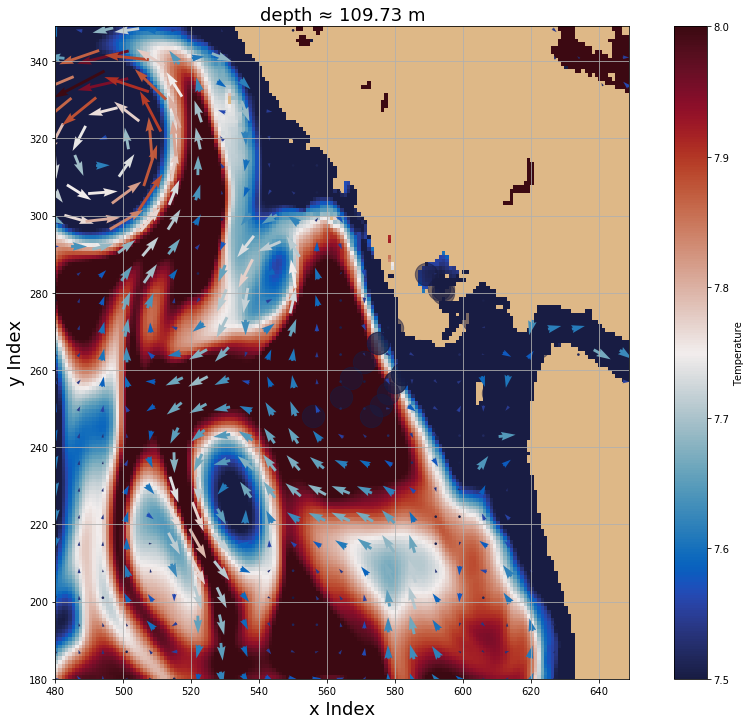

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(16,12))

axs, mesh = plot_temp_subplot(level= 22, ax= axs, cmin = 7.5, cmax = 8)
cbar = fig.colorbar(mesh, ax=axs, label='Temperature')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


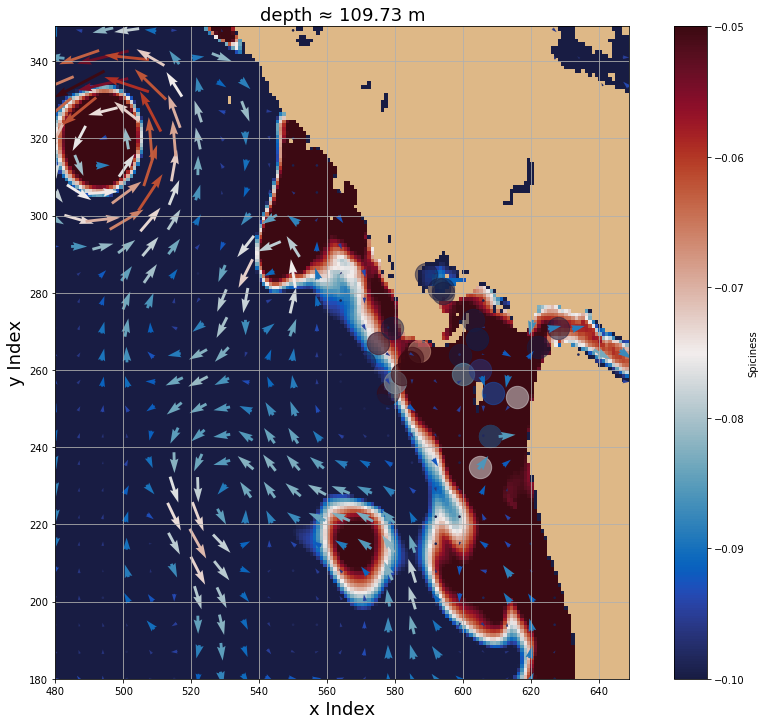

In [61]:
fig, axs = plt.subplots(1, 1, figsize=(16,12))

axs, mesh = plot_spic_subplot(level= 22, ax= axs, cmin = -0.1, cmax = -0.05)
cbar = fig.colorbar(mesh, ax=axs, label='Spiciness')

In [72]:

lon_W01 = -124.82500
lat_W01 = 48.31500

y, x = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})      

print(y, x)

lon_W02 = -124.89500
lat_W02 = 48.04167

y, x = geo_tools.find_closest_model_point(lon_W02,lat_W02,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

print(y, x)

259 623
239 622


In [74]:
fig, axs = plt.subplots(1, 1, figsize=(16,12))

axs, mesh = plot_sal_subplot(level= 22, ax= axs, cmin = 33.4, cmax = 34.2)
cbar = fig.colorbar(mesh, ax=axs, label='Practical Salinity (PSU)')
axs.scatter(623, 259, s=500, c= 'magenta', alpha=0.8, label = 'W01')
axs.scatter(622, 239, s=500, c= 'cyan', alpha=0.8, label = 'W02')
legend = axs.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [13]:
def falkor_locations(profile):

    pressure = profile['PRES'][:]
    PT = profile['potemperature'][:]
    T = profile['TEMP'][:]
    SP = profile['PSAL'][:]
    lat = np.nanmean(profile['LATITUDE'][:])
    lon = np.nanmean(profile['LONGITUDE'][:])
    
    z = gsw.z_from_p(-pressure, lat)
    
    falkor_scalar_ts = namedtuple('falkor_scalar_ts', 'temp, sal, lat, lon, z')

    return falkor_scalar_ts(PT, SP, lat, lon, z)

In [29]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


file = []

i = 0
for file_number in sorted(glob.glob('/home/ssahu/saurav/Falkor_code/*.cnv')):
    
    file.append(file_number)
    
    i = i+1


In [15]:
temp_location = []
sal_location = []
lat_location = []
lon_location = []
z_location = []
# sal_location[j,:] = falkor_scalar_ts[1]
# lat_location[j] = falkor_scalar_ts[2]
# lon_location[j] = falkor_scalar_ts[3]


time_location = []

for example in file:
    time_location = np.append(arr= time_location, values= example[51:-4])
    
time_location = time_location.astype(int)
time_location[:] = time_location[:] + 112 

for j in np.arange(len(file)):

    falkor_scalar_ts = falkor_locations(fCNV(file[j]))
    
    
    temp_that_file = np.empty(falkor_scalar_ts[0].shape)
    temp_that_file = falkor_scalar_ts[0]
    temp_location.append(temp_that_file)
    
    sal_that_file = np.empty(falkor_scalar_ts[1].shape)
    sal_that_file = falkor_scalar_ts[1]
    sal_location.append(sal_that_file)
    
    
    z_that_file = np.empty(falkor_scalar_ts[4].shape)
    z_that_file = falkor_scalar_ts[4]
    z_location.append(z_that_file)    
    
    lat_that_file = np.empty(falkor_scalar_ts[2].shape)
    lat_that_file = falkor_scalar_ts[2]
    lat_location.append(lat_that_file)
    
    lon_that_file = np.empty(falkor_scalar_ts[3].shape)
    lon_that_file = falkor_scalar_ts[3]
    lon_location.append(lon_that_file)
    
    
    

    
temp_location = np.array(temp_location)
sal_location = np.array(sal_location)
z_location = np.array(z_location)
lat_location = np.array(lat_location)
lon_location = np.array(lon_location)



DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD002_20130819.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD003_20130819.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD004_20130819.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD005_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD006_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD007_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD008_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD009_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD010_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD011_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD012_20130820.cnv
DEBUG:root:Openning file: /home/ssahu/saurav/Falkor_code/FK009A_CTD013_20130

In [75]:
SA_falk_loc = np.empty_like(sal_location)
CT_falk_loc = np.empty_like(temp_location)
pressure_falk_loc = np.empty_like(z_location)
spic_falk_loc = np.empty_like(sal_location)


for i in np.arange(lat_location.shape[0]):
    
    pressure_falk_loc[i] = gsw.p_from_z(-z_location[i],lat_location[i])
    
    SA_falk_loc[i] = gsw.SA_from_SP(sal_location[i], pressure_falk_loc[i], lon_location[i], lat_location[i])
    
    CT_falk_loc[i] = gsw.CT_from_pt(sal_location[i], temp_location[i])
    
    spic_falk_loc[i] = gsw.spiciness0(SA_falk_loc[i], CT_falk_loc[i])

    

In [13]:
def spice_bathy_plot_date(t, level, file_number):
    spic_tzyx = spic[t,level,...]
    spic_tzyx = np.ma.masked_array(spic_tzyx, mask= 1- tmask[level,...])


    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8)); ax1.grid()
    viz_tools.set_aspect(ax1)
    cmap = plt.get_cmap('Blues_r')
    cmap.set_bad('burlywood')
    p = ax1.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)#, vmax=500)
    ax1.scatter(x[file_number], y[file_number], c='orangered', s=100, alpha=0.6, label = 'Falkor Point')
    legend = ax1.legend(loc='best', fancybox=True, framealpha=0.25)
    ax1.set_xlabel('x Index',fontsize=18)
    ax1.set_ylabel('y Index',fontsize=18)
    # ax.set_ylim([lat[270:350,550:650].min(), lat[270:350,550:650].max()])
    ax1.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)
    # viz_tools.plot_land_mask(ax1, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    cbar = fig.colorbar(p, ax=ax1, label='Depth [m]')



    viz_tools.set_aspect(ax2)
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('burlywood')
    mesh = ax2.pcolormesh(x_wcvi_slice,y_wcvi_slice, spic_tzyx, cmap=cmap, vmin = -0.1, vmax = -0.05)

    viz_tools.plot_land_mask(ax2, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
    ax2.scatter(x[file_number], y[file_number], c='cyan', s=100, alpha=0.6, label = 'Falkor Point')
    ax2.grid()
    # ax2.set_xlim(x_wcvi_slice[0], x_wcvi_slice[-1])
    # ax2.set_ylim(y_wcvi_slice[0], y_wcvi_slice[-1])
    ax2.set_xlabel('x Index',fontsize=18)
    ax2.set_ylabel('y Index',fontsize=18)
    if t <= 1:
        month = 'April'
        ax2.set_title('{0} April 2013, depth \u2248 {d:.2f} m'.format(t+29, d=zlevels[level]))

    if 1 < t <=32:
        month = 'May'
        ax2.set_title('{0} May 2013, depth \u2248 {d:.2f} m'.format(t-1, d=zlevels[level]))

    if 32 < t <= 62:
        month = 'June'
        ax2.set_title('{0} June 2013, depth \u2248 {d:.2f} m'.format(t-32, d=zlevels[level]))

    if 62 < t <= 93:
        month = 'July'
        ax2.set_title('{0} July 2013, depth \u2248 {d:.2f} m'.format(t-62, d=zlevels[level]))

    if 93 < t <= 124:
        month = 'August'
        ax2.set_title('{0} August 2013, depth \u2248 {d:.2f} m'.format(t-93, d=zlevels[level]))

    if 124 < t <= 154:
        month = 'September'
        ax2.set_title('Spiciness on {0} September 2013, at isopycnal level of \u2248 {d:.2f} '.format(t-114, d=zlevels[level]))

    if 154 < t <= 185:
        month = 'October'
        ax2.set_title('Spiciness on {0} October 2013, at isopycnal level of \u2248 {d:.2f} '.format(t-154, d=zlevels[level]))


    # ax2.set_title('{0} August 2015, depth \u2248 {d:.2f} m'.format(t_aug+1, d=zlevels[level], z=zlevels),fontsize=18)
    cbar = fig.colorbar(mesh, ax=ax2, label='Spiciness')
    legend = ax2.legend(loc='best', fancybox=True, framealpha=0.25)
    
def compare_plots(t, file_number):
    temp_position = temp[t,:mbathy[y[file_number],x[file_number]],n[file_number],m[file_number]]
    sal_position  = sal[t,:mbathy[y[file_number],x[file_number]],n[file_number],m[file_number]]
    spic_position = spic[t,:mbathy[y[file_number],x[file_number]],n[file_number],m[file_number]]



    fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))
    # Temperature
    ax2.plot(temp_position,zlevels[:mbathy[y[file_number],x[file_number]]],'r',label = 'NEP36 model')
    ax2.plot(temp_location[file_number],z_location[file_number],'b',label='Falkor data')
    ax2.set_ylabel('Depth (m)')
    ax2.set_ylim(ax2.get_ylim()[::-1]) 
    ax2.set_xlabel('Temperature (C)')
    ax2.xaxis.set_label_position('top') 
    ax2.xaxis.set_ticks_position('top') 
    legend = ax2.legend(loc='best', fancybox=True, framealpha=0.25)
    # Salinity
    ax3.plot(sal_position,zlevels[:mbathy[y[file_number],x[file_number]]],'r',label = 'NEP36 model')
    ax3.plot(sal_location[file_number],z_location[file_number],'b',label='Falkor data')
    ax3.set_xlabel('Salinity')
    ax3.xaxis.set_label_position('top') 
    ax3.xaxis.set_ticks_position('top') 
    ax3.yaxis.set_visible(False) 
    legend = ax3.legend(loc='best', fancybox=True, framealpha=0.25)
    # Spiciness
    ax4.plot(spic_position,zlevels[:mbathy[y[file_number],x[file_number]]],'r',label = 'NEP36 model')
    ax4.plot(spic_falk_loc[file_number],z_location[file_number],'b',label='Falkor data')
    ax4.set_xlabel('Spiciness')
    ax4.set_xlim(-1.2,0)
    ax4.xaxis.set_label_position('top') 
    ax4.xaxis.set_ticks_position('top') 
    ax4.yaxis.set_visible(False) 
    legend = ax4.legend(loc='best', fancybox=True, framealpha=0.25)

/home/ssahu/saurav/Falkor_code/FK009A_CTD002_20130819.cnv


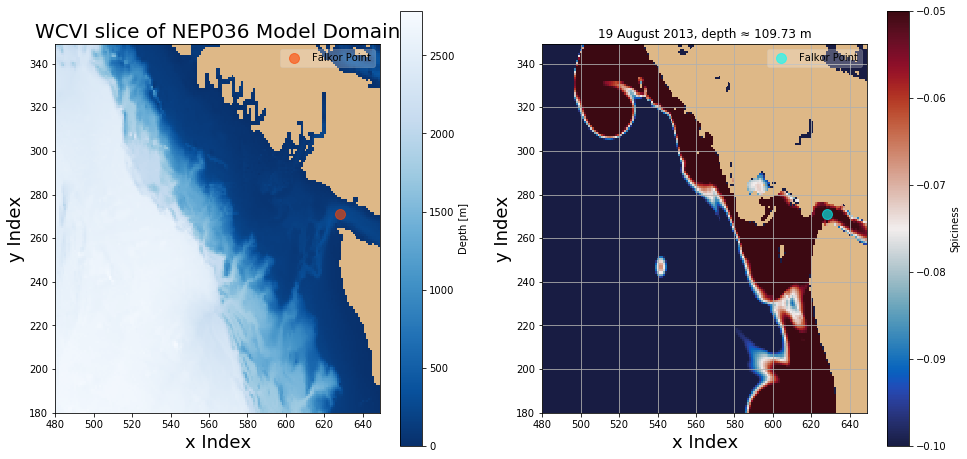

In [82]:
t = 102
level = 22
file_number = 0
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

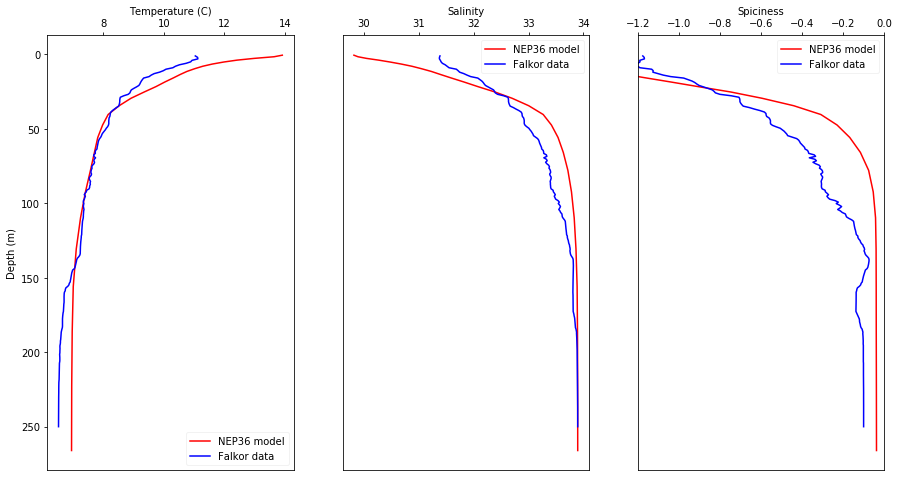

In [121]:
compare_plots(t = 102, file_number=0)

/home/ssahu/saurav/Falkor_code/FK009A_CTD003_20130819.cnv


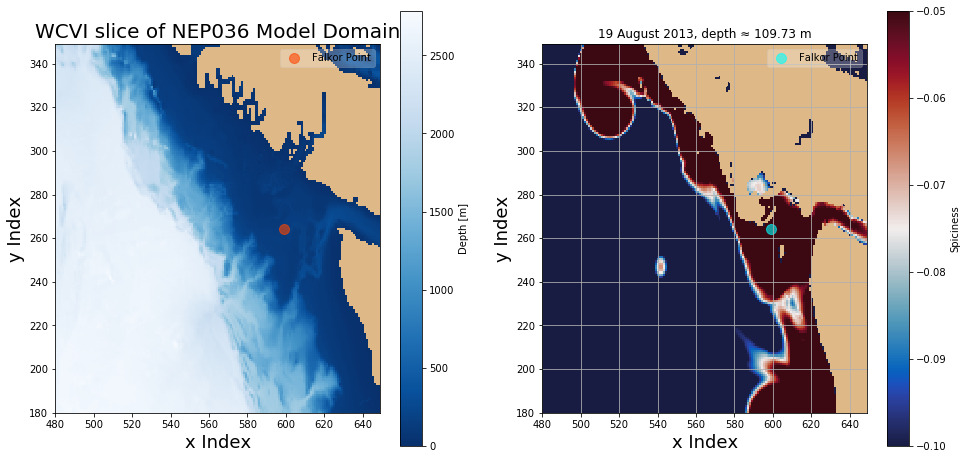

In [123]:
t = 102
level = 22
file_number = 1
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

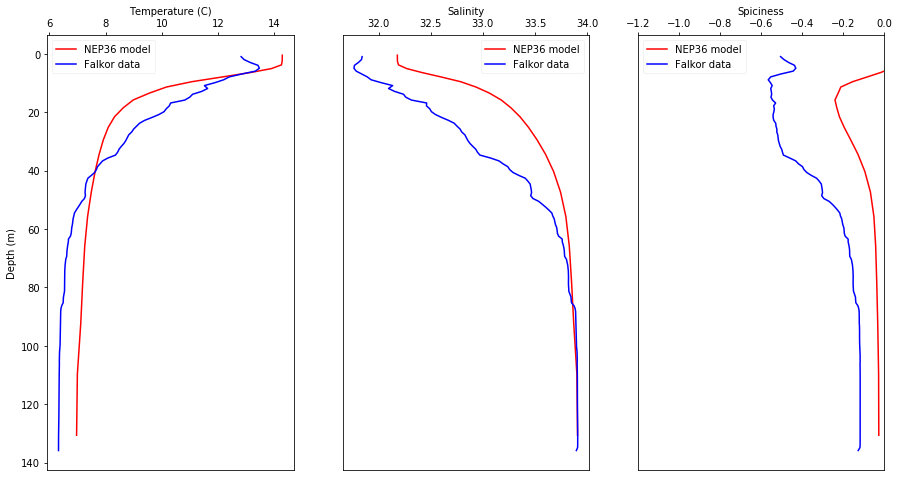

In [124]:
compare_plots(t = 102, file_number=1)

/home/ssahu/saurav/Falkor_code/FK009A_CTD004_20130819.cnv


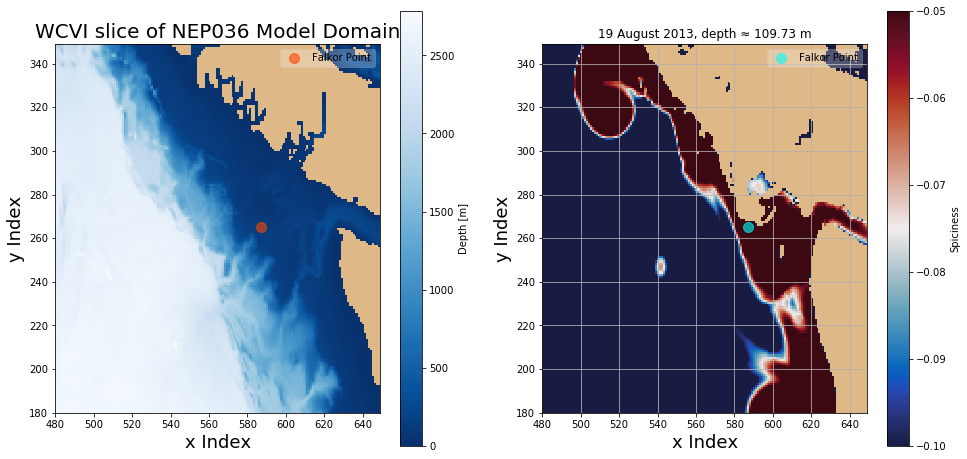

In [125]:
t = 102
level = 22
file_number = 2
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

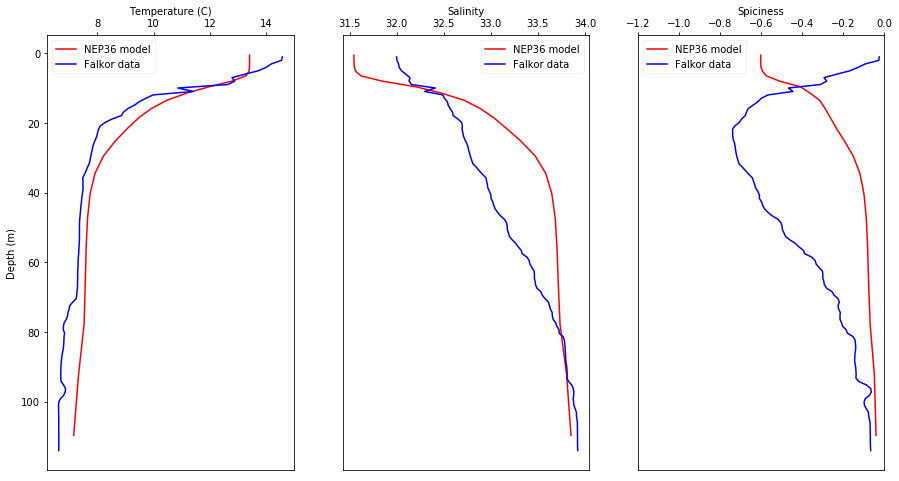

In [126]:
compare_plots(t = 102, file_number=2)

/home/ssahu/saurav/Falkor_code/FK009A_CTD005_20130820.cnv


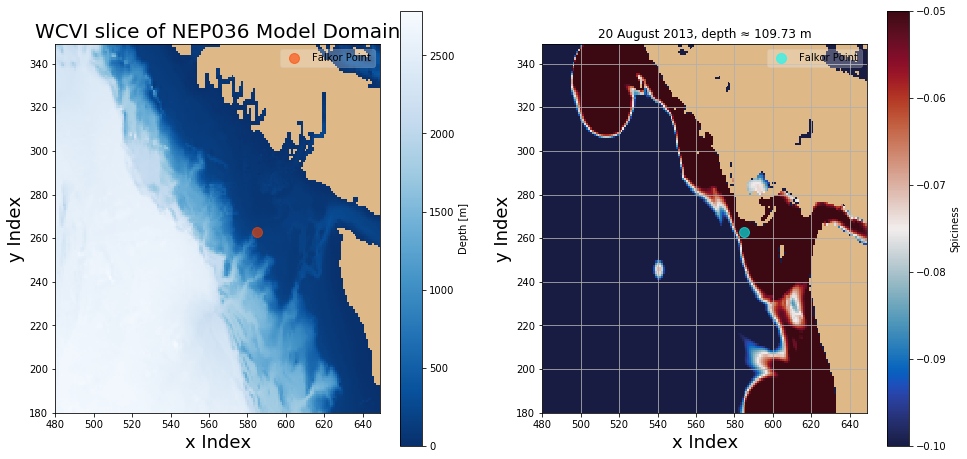

In [128]:
t = 103
level = 22
file_number = 3
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

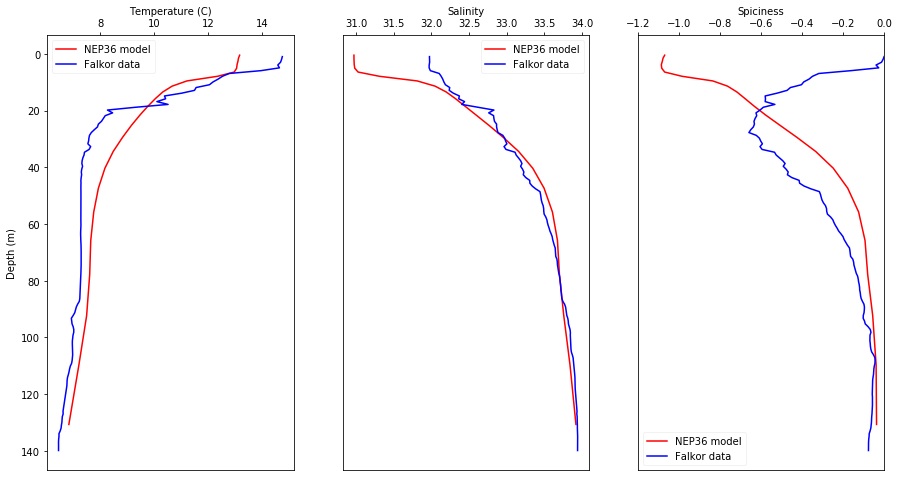

In [129]:
compare_plots(t = 103, file_number=3)

In [132]:
t = 103
level = 22
file_number = 4
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD006_20130820.cnv


In [133]:
compare_plots(t = 103, file_number=4)

In [134]:
t = 103
level = 22
file_number = 5
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD007_20130820.cnv


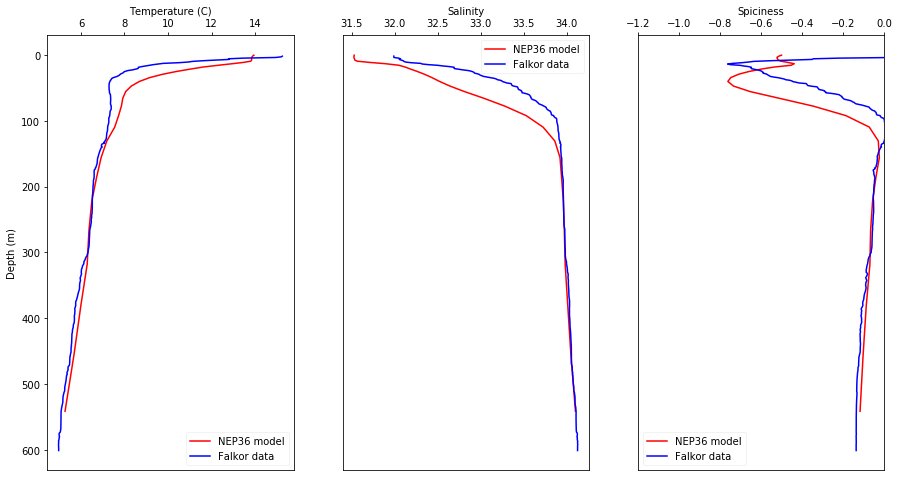

In [135]:
compare_plots(t = 103, file_number=5)

/home/ssahu/saurav/Falkor_code/FK009A_CTD008_20130820.cnv


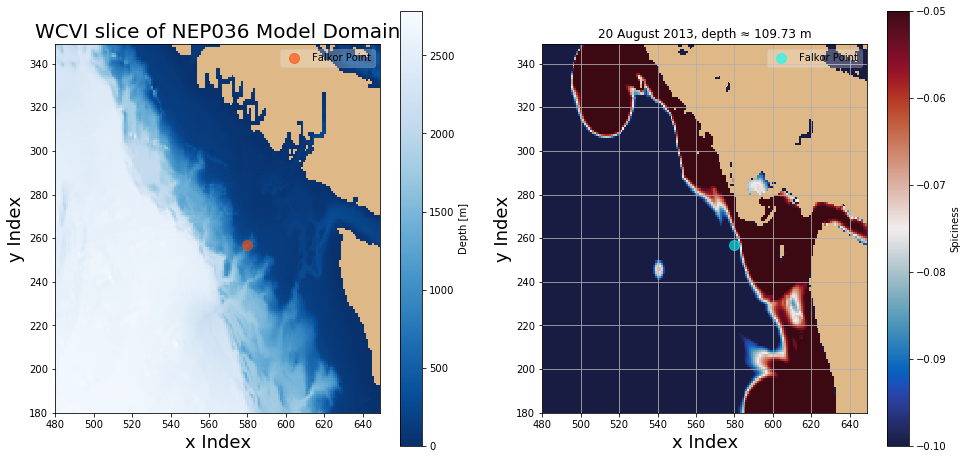

In [136]:
t = 103
level = 22
file_number = 6
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

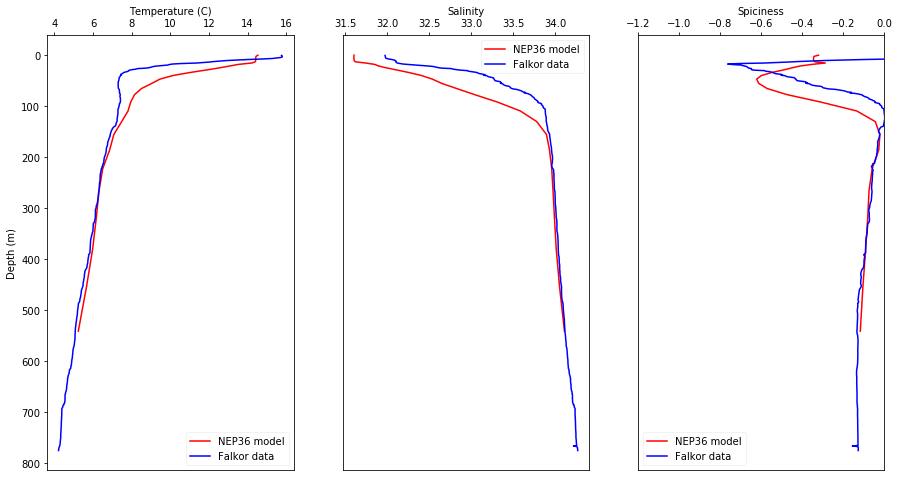

In [137]:
compare_plots(t, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD009_20130820.cnv


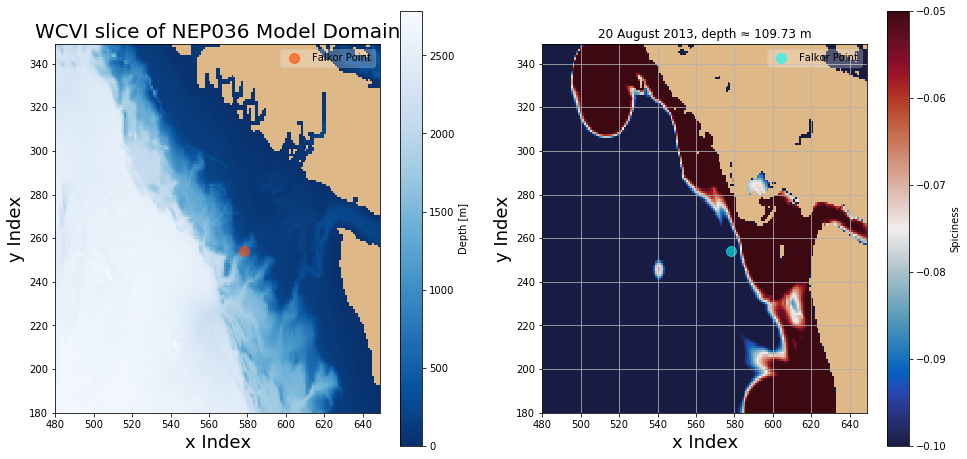

In [138]:
t = 103
level = 22
file_number = 7
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

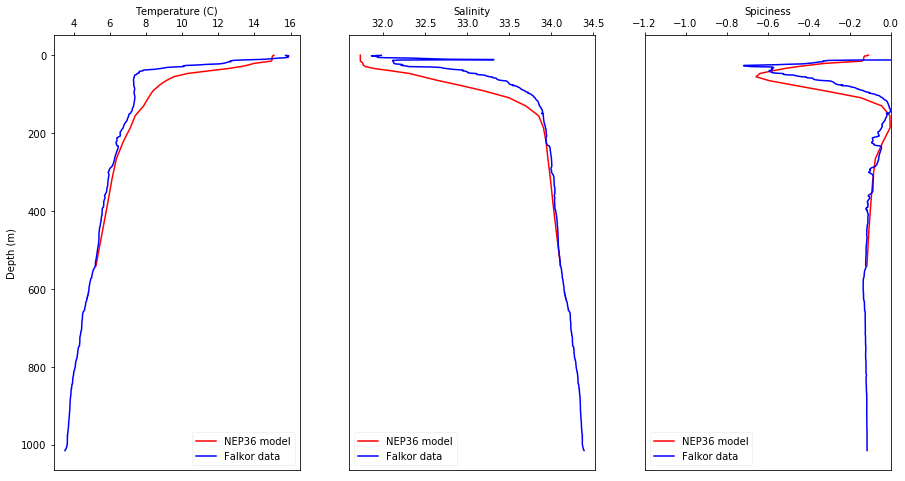

In [139]:
compare_plots(t, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD010_20130820.cnv


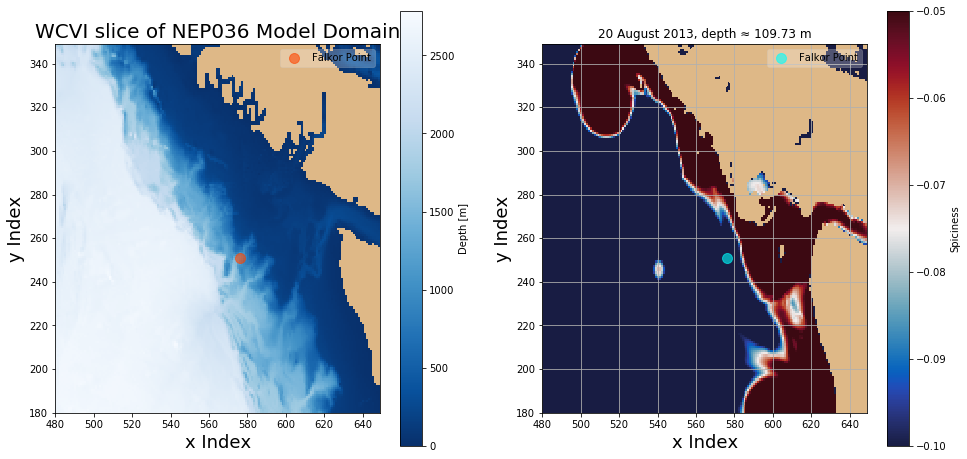

In [140]:
t = 103
level = 22
file_number = 8
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

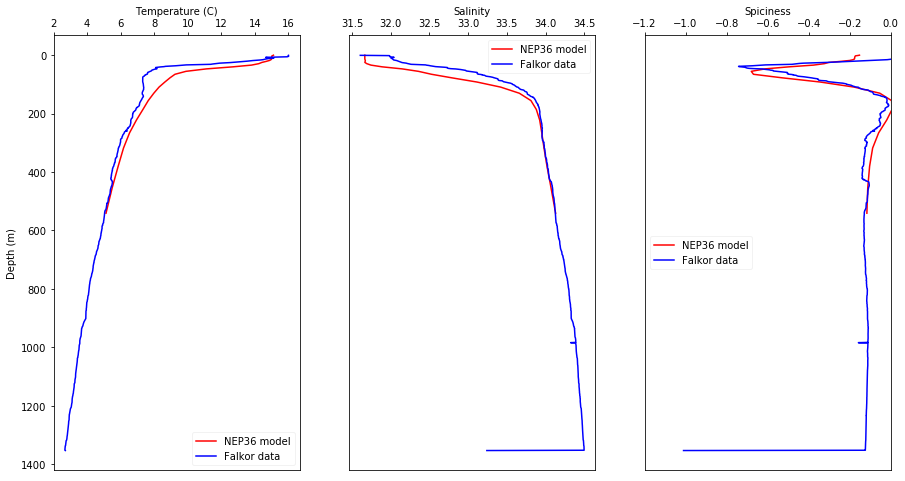

In [141]:
compare_plots(t, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD011_20130820.cnv


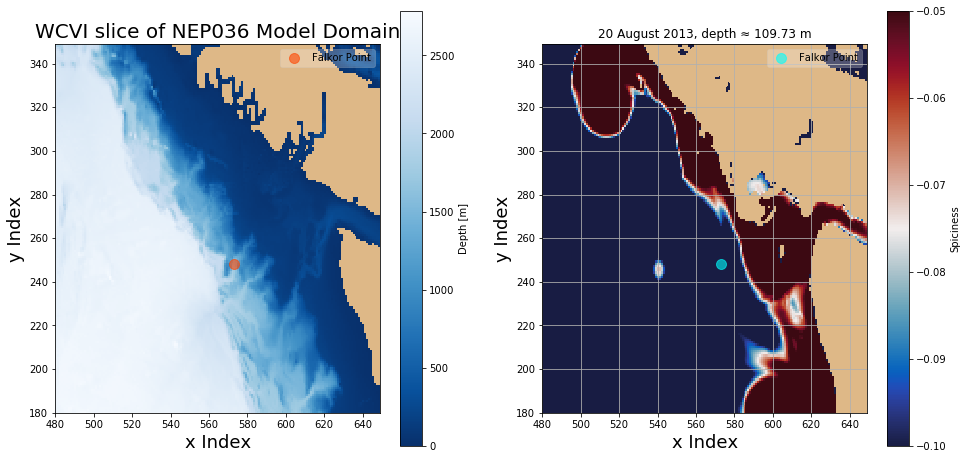

In [149]:
t = 103
level = 22
file_number = 9
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

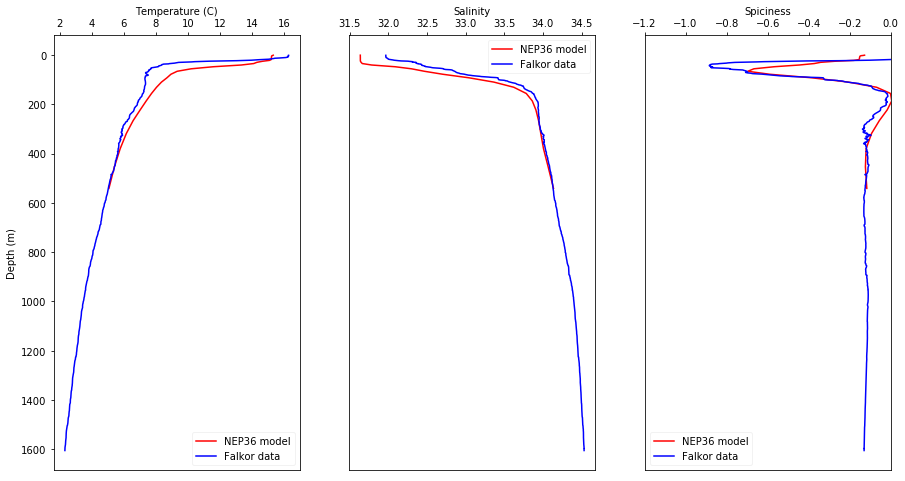

In [150]:
compare_plots(t, file_number)

/home/ssahu/saurav/Falkor_code/FK009A_CTD016_20130821.cnv


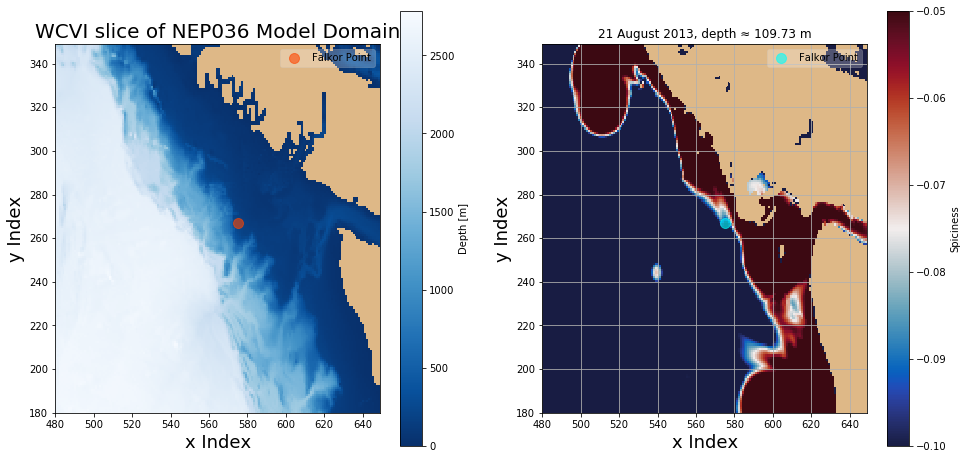

In [147]:
t = 104
level = 22
file_number = 14
print(file[file_number])



spice_bathy_plot_date(t, level, file_number)

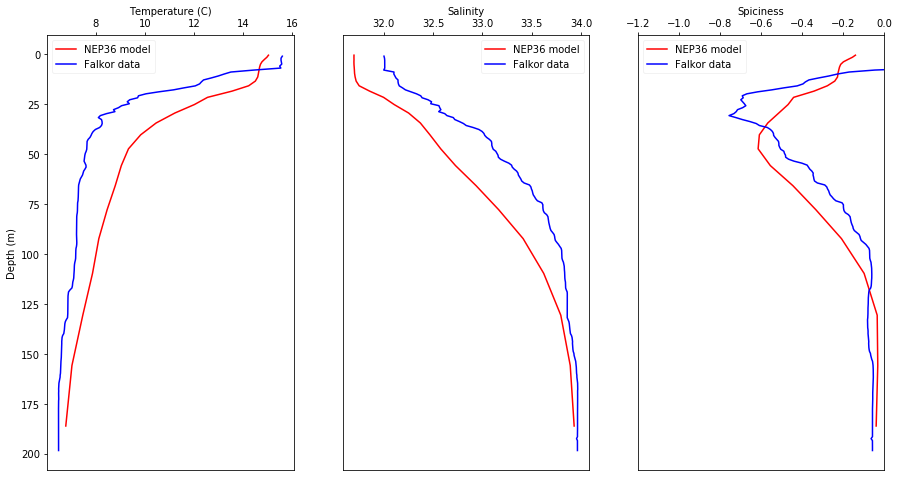

In [148]:
compare_plots(t, file_number)

In [99]:
temp_position = temp[t,:mbathy[y[file_number],x[file_number]],y[file_number],x[file_number]]

IndexError: 

In [100]:
t

102

In [101]:
temp.shape

(180, 32, 170, 170)

91.0

In [23]:
file[0]

'/home/ssahu/saurav/Falkor_code/FK009A_CTD002_20130819.cnv'

In [83]:
def add_model_data_to_bin_at_station_locations(file_number, z_bin_1, z_bin_2, z_bin_3,\
                    tem_bin_1, tem_bin_2, tem_bin_3, \
                   sal_bin_1, sal_bin_2, sal_bin_3, \
                   spic_bin_1, spic_bin_2, spic_bin_3):
    
    t = time_location[file_number]
    j = n[file_number]
    i = m[file_number]
        
    model_temp_ini = temp[t,:mbathy[j,i],j,i]
    model_temp = model_temp_ini[np.nonzero(model_temp_ini)]

    model_sal_ini = sal[t,:mbathy[j,i],j,i]
    model_sal = model_sal_ini[np.nonzero(model_sal_ini)]

    model_spice_ini = spic[t,:mbathy[j,i],j,i]
    model_spice = model_spice_ini[np.nonzero(model_sal_ini)]

    

    z_obs = np.array(z_location[file_number])

    
    
    
    func_temp = interp1d(zlevels[:model_temp.shape[0]], model_temp, fill_value='extrapolate')
    model_temp_interp = func_temp(z_obs)
    
    
    func_sal = interp1d(zlevels[:model_sal.shape[0]], model_sal, fill_value='extrapolate')
    model_sal_interp = func_sal(z_obs)
    
    func_spic = interp1d(zlevels[:model_spice.shape[0]], model_spice, fill_value='extrapolate')
    model_spice_interp = func_spic(z_obs)
    
        
    
    
       
    z_data_bin_1    = z_obs[np.where(z_obs < 50)]

    tem_data_bin_1  = model_temp_interp[np.where(z_obs < 50)]

    sal_data_bin_1  = model_sal_interp[np.where(z_obs < 50)]

    spic_data_bin_1 = model_spice_interp[np.where(z_obs < 50)]
    

    z_data_bin_2    = z_obs[np.where((z_obs >= 50) & (z_obs < 100))]

    tem_data_bin_2  = model_temp_interp[np.where((z_obs >= 50) & (z_obs < 100))]

    sal_data_bin_2  = model_sal_interp[np.where((z_obs >= 50) & (z_obs < 100))]

    spic_data_bin_2 = model_spice_interp[np.where((z_obs >= 50) & (z_obs < 100))]
    

    z_data_bin_3    = z_obs[np.where((z_obs >= 100))]

    tem_data_bin_3  = model_temp_interp[np.where((z_obs >= 100))]

    sal_data_bin_3  = model_sal_interp[np.where((z_obs >= 100))]

    spic_data_bin_3 = model_spice_interp[np.where((z_obs >= 100))]
    
    
    z_bin_1 = np.append(arr= z_bin_1, values= z_data_bin_1)
    z_bin_2 = np.append(arr= z_bin_2, values= z_data_bin_2)
    z_bin_3 = np.append(arr= z_bin_3, values= z_data_bin_3)
    
    tem_bin_1 = np.append(arr= tem_bin_1, values= tem_data_bin_1)
    tem_bin_2 = np.append(arr= tem_bin_2, values= tem_data_bin_2)
    tem_bin_3 = np.append(arr= tem_bin_3, values= tem_data_bin_3)
    
    sal_bin_1 = np.append(arr= sal_bin_1, values= sal_data_bin_1)
    sal_bin_2 = np.append(arr= sal_bin_2, values= sal_data_bin_2)
    sal_bin_3 = np.append(arr= sal_bin_3, values= sal_data_bin_3)
    
    spic_bin_1 = np.append(arr= spic_bin_1, values= spic_data_bin_1)
    spic_bin_2 = np.append(arr= spic_bin_2, values= spic_data_bin_2)
    spic_bin_3 = np.append(arr= spic_bin_3, values= spic_data_bin_3)
    
    return z_bin_1, z_bin_2, z_bin_3, tem_bin_1, tem_bin_2, tem_bin_3, sal_bin_1, sal_bin_2, sal_bin_3, spic_bin_1, spic_bin_2, spic_bin_3
    

    
    
    
    
    

In [84]:
z_bin_1_m = []
z_bin_2_m = []
z_bin_3_m = []

tem_bin_1_m = []
tem_bin_2_m = []
tem_bin_3_m = []

sal_bin_1_m = []
sal_bin_2_m = []
sal_bin_3_m = []

spic_bin_1_m = []
spic_bin_2_m = []
spic_bin_3_m = []


for file_number in np.arange(len(file)):
    z_bin_1_m, z_bin_2_m, z_bin_3_m, \
    tem_bin_1_m, tem_bin_2_m,tem_bin_3_m, \
    sal_bin_1_m, sal_bin_2_m, sal_bin_3_m, \
    spic_bin_1_m, spic_bin_2_m, spic_bin_3_m = add_model_data_to_bin_at_station_locations(file_number, z_bin_1_m, z_bin_2_m, z_bin_3_m,\
                                                         tem_bin_1_m, tem_bin_2_m, tem_bin_3_m, \
                                                         sal_bin_1_m, sal_bin_2_m, sal_bin_3_m, \
                                                         spic_bin_1_m, spic_bin_2_m, spic_bin_3_m)
    


In [85]:
def add_data_to_bin(file_number, z_bin_1, z_bin_2, z_bin_3,\
                    tem_bin_1, tem_bin_2, tem_bin_3, \
                   sal_bin_1, sal_bin_2, sal_bin_3, \
                   spic_bin_1, spic_bin_2, spic_bin_3):
    



    z_data = z_location[file_number]

    tem_data = temp_location[file_number]

    sal_data = sal_location[file_number]

    spic_data = spic_falk_loc[file_number]
    
       
    z_data_bin_1    = z_data[np.where(z_data < 50)]

    tem_data_bin_1  = tem_data[np.where(z_data < 50)]

    sal_data_bin_1  = sal_data[np.where(z_data < 50)]

    spic_data_bin_1 = spic_data[np.where(z_data < 50)]
    

    z_data_bin_2    = z_data[np.where((z_data >= 50) & (z_data < 100))]

    tem_data_bin_2  = tem_data[np.where((z_data >= 50) & (z_data < 100))]

    sal_data_bin_2  = sal_data[np.where((z_data >= 50) & (z_data < 100))]

    spic_data_bin_2 = spic_data[np.where((z_data >= 50) & (z_data < 100))]
    

    z_data_bin_3    = z_data[np.where((z_data >= 100))]

    tem_data_bin_3  = tem_data[np.where((z_data >= 100))]

    sal_data_bin_3  = sal_data[np.where((z_data >= 100))]

    spic_data_bin_3 = spic_data[np.where((z_data >= 100))]
    
    
    z_bin_1 = np.append(arr= z_bin_1, values= z_data_bin_1)
    z_bin_2 = np.append(arr= z_bin_2, values= z_data_bin_2)
    z_bin_3 = np.append(arr= z_bin_3, values= z_data_bin_3)
    
    tem_bin_1 = np.append(arr= tem_bin_1, values= tem_data_bin_1)
    tem_bin_2 = np.append(arr= tem_bin_2, values= tem_data_bin_2)
    tem_bin_3 = np.append(arr= tem_bin_3, values= tem_data_bin_3)
    
    sal_bin_1 = np.append(arr= sal_bin_1, values= sal_data_bin_1)
    sal_bin_2 = np.append(arr= sal_bin_2, values= sal_data_bin_2)
    sal_bin_3 = np.append(arr= sal_bin_3, values= sal_data_bin_3)
    
    spic_bin_1 = np.append(arr= spic_bin_1, values= spic_data_bin_1)
    spic_bin_2 = np.append(arr= spic_bin_2, values= spic_data_bin_2)
    spic_bin_3 = np.append(arr= spic_bin_3, values= spic_data_bin_3)
    
    return z_bin_1, z_bin_2, z_bin_3, tem_bin_1, tem_bin_2, tem_bin_3, sal_bin_1, sal_bin_2, sal_bin_3, spic_bin_1, spic_bin_2, spic_bin_3
    

    
    
    
    
    

In [86]:
z_bin_1 = []
z_bin_2 = []
z_bin_3 = []

tem_bin_1 = []
tem_bin_2 = []
tem_bin_3 = []

sal_bin_1 = []
sal_bin_2 = []
sal_bin_3 = []

spic_bin_1 = []
spic_bin_2 = []
spic_bin_3 = []


for file_number in np.arange(len(file)):
    z_bin_1, z_bin_2, z_bin_3, \
    tem_bin_1, tem_bin_2,tem_bin_3, \
    sal_bin_1, sal_bin_2, sal_bin_3, \
    spic_bin_1, spic_bin_2, spic_bin_3 = add_data_to_bin(file_number, z_bin_1, z_bin_2, z_bin_3,\
                                                         tem_bin_1, tem_bin_2, tem_bin_3, \
                                                         sal_bin_1, sal_bin_2, sal_bin_3, \
                                                         spic_bin_1, spic_bin_2, spic_bin_3)
    

In [159]:
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

def get_stat_tem(obs_temp, model_temp, z_data):
    
#     func_temp = interp1d(zlevels[:model_temp.shape[0]], model_temp, fill_value='extrapolate')
#     model_temp_interp = func_temp(z_data)
    
    model_temp_interp = model_temp

    obar = np.nanmean(obs_temp)
    mprime = model_temp_interp - obar
    oprime = obs_temp - obar

    diff_sq = np.sum((model_temp_interp-obs_temp)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_temp_interp - obs_temp
    gamma2 = np.var(error)/np.var(obs_temp)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws

def get_stat_sal(obs_sal, model_sal, z_data):
    
#     func_temp = interp1d(zlevels[:model_temp.shape[0]], model_temp, fill_value='extrapolate')
#     model_temp_interp = func_temp(z_data)
    
    model_temp_interp = model_sal
    obs_temp = obs_sal

    obar = np.nanmean(obs_temp)
    mprime = model_temp_interp - obar
    oprime = obs_temp - obar

    diff_sq = np.sum((model_temp_interp-obs_temp)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_temp_interp - obs_temp
    gamma2 = np.var(error)/np.var(obs_temp)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws

def get_stat_spice(obs_spice, model_spice, z_data):
    
#     func_temp = interp1d(zlevels[:model_temp.shape[0]], model_temp, fill_value='extrapolate')
#     model_temp_interp = func_temp(z_data)
    
    model_temp_interp = model_spice
    obs_temp = obs_spice

    obar = np.nanmean(obs_temp)
    mprime = model_temp_interp - obar
    oprime = obs_temp - obar

    diff_sq = np.sum((model_temp_interp-obs_temp)**2)
    add_sq = np.sum((np.abs(mprime) + np.abs(oprime))**2)

    ws = 1-diff_sq/add_sq



    error = model_temp_interp - obs_temp
    gamma2 = np.var(error)/np.var(obs_temp)
    mean_error = np.mean(error)
    mean_abs_error = np.mean(np.abs(error))
    rms_error = np.sqrt(np.mean(error**2))
    
    return gamma2,rms_error,ws



def plot_stat_bin_1(obs_temp, model_temp, obs_sal, model_sal, obs_spice, model_spice, z_data):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))




    gamma2,rms_error,ws = get_stat_tem(obs_temp, model_temp, z_data)
    df =pd.DataFrame()
    df['Observed_temp'] = obs_temp
    df['Model_temp'] = model_temp
    sns.regplot(x="Observed_temp", y="Model_temp", data=df, color='teal', ax=ax1, fit_reg=False)
    ax1.set_title('Model vs Observed Temperature for Bin 1 (< 50m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax1.add_artist(anchored_text)
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax1.set_aspect('equal')
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)



    gamma2,rms_error,ws = get_stat_sal(obs_sal, model_sal, z_data)
    df =pd.DataFrame()
    df['Observed_Salinity'] = obs_sal
    df['Model_Salinity'] = model_sal
    sns.regplot(x="Observed_Salinity", y="Model_Salinity", data=df, color='blue', ax = ax2, fit_reg=False)
    ax2.set_title('Model vs Observed Salinity for Bin 1 (< 50m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax2.add_artist(anchored_text)
    lims = [
        np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]

    ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax2.set_aspect('equal')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)


    gamma2,rms_error,ws = get_stat_spice(obs_spice, model_spice, z_data)
    df =pd.DataFrame()
    df['Observed_Spice'] = obs_spice
    df['Model_Spice'] = model_spice
    sns.regplot(x="Observed_Spice", y="Model_Spice", data=df, color='orangered', ax = ax3, fit_reg=False)
    ax3.set_title('Model vs Observed Spice for Bin 1 (< 50m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax3.add_artist(anchored_text)
    lims = [
        np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
        np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
    ]

    ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax3.set_aspect('equal')
    ax3.set_xlim(lims)
    ax3.set_ylim(lims)

    
    
def plot_stat_bin_2(obs_temp, model_temp, obs_sal, model_sal, obs_spice, model_spice, z_data):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))




    gamma2,rms_error,ws = get_stat_tem(obs_temp, model_temp, z_data)
    df =pd.DataFrame()
    df['Observed_temp'] = obs_temp
    df['Model_temp'] = model_temp
    sns.regplot(x="Observed_temp", y="Model_temp", data=df, color='teal', ax=ax1, fit_reg=False)
    ax1.set_title('Model vs Observed Temperature for Bin 1 (50m < z < 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax1.add_artist(anchored_text)
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax1.set_aspect('equal')
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)



    gamma2,rms_error,ws = get_stat_sal(obs_sal, model_sal, z_data)
    df =pd.DataFrame()
    df['Observed_Salinity'] = obs_sal
    df['Model_Salinity'] = model_sal
    sns.regplot(x="Observed_Salinity", y="Model_Salinity", data=df, color='blue', ax = ax2, fit_reg=False)
    ax2.set_title('Model vs Observed Salinity for Bin 2 (50m < z < 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax2.add_artist(anchored_text)
    lims = [
        np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]

    ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax2.set_aspect('equal')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)


    gamma2,rms_error,ws = get_stat_spice(obs_spice, model_spice, z_data)
    df =pd.DataFrame()
    df['Observed_Spice'] = obs_spice
    df['Model_Spice'] = model_spice
    sns.regplot(x="Observed_Spice", y="Model_Spice", data=df, color='orangered', ax = ax3, fit_reg=False)
    ax3.set_title('Model vs Observed Spice for Bin 1 (50m < z < 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax3.add_artist(anchored_text)
    lims = [
        np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
        np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
    ]

    ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax3.set_aspect('equal')
    ax3.set_xlim(lims)
    ax3.set_ylim(lims)

def plot_stat_bin_3(obs_temp, model_temp, obs_sal, model_sal, obs_spice, model_spice, z_data):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,20))




    gamma2,rms_error,ws = get_stat_tem(obs_temp, model_temp, z_data)
    df =pd.DataFrame()
    df['Observed_temp'] = obs_temp
    df['Model_temp'] = model_temp
    sns.regplot(x="Observed_temp", y="Model_temp", data=df, color='teal', ax=ax1, fit_reg=False)
    ax1.set_title('Model vs Observed Temperature for Bin 3 (z > 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax1.add_artist(anchored_text)
    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax1.set_aspect('equal')
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)



    gamma2,rms_error,ws = get_stat_sal(obs_sal, model_sal, z_data)
    df =pd.DataFrame()
    df['Observed_Salinity'] = obs_sal
    df['Model_Salinity'] = model_sal
    sns.regplot(x="Observed_Salinity", y="Model_Salinity", data=df, color='blue', ax = ax2, fit_reg=False)
    ax2.set_title('Model vs Observed Salinity for Bin 3 (z > 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax2.add_artist(anchored_text)
    lims = [
        np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]

    ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax2.set_aspect('equal')
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)


    gamma2,rms_error,ws = get_stat_spice(obs_spice, model_spice, z_data)
    df =pd.DataFrame()
    df['Observed_Spice'] = obs_spice
    df['Model_Spice'] = model_spice
    sns.regplot(x="Observed_Spice", y="Model_Spice", data=df, color='orangered', ax = ax3, fit_reg=False)
    ax3.set_title('Model vs Observed Spice for Bin 3 (z > 100m)')
    anchored_text = AnchoredText("Willmott Score \u2248 {w:.2f}, RMSE \u2248 {r:.2f} and Bias \u2248 {b:.2f}". format(w = ws, r = rms_error, b = gamma2),loc=2)
    ax3.add_artist(anchored_text)
    lims = [
        np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
        np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
    ]

    ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax3.set_aspect('equal')
    ax3.set_xlim(lims)
    ax3.set_ylim(lims)




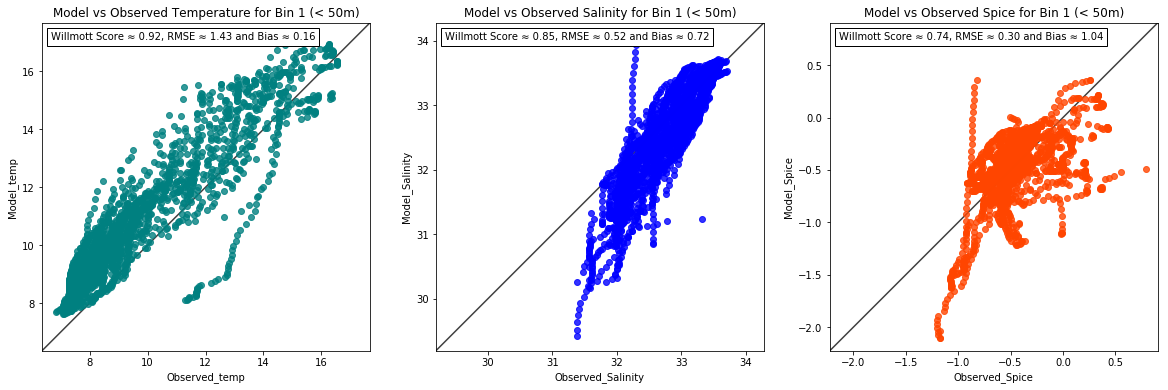

In [162]:
plot_stat_bin_1(obs_temp=tem_bin_1, model_temp=tem_bin_1_m, obs_sal=sal_bin_1, model_sal= sal_bin_1_m, \
          obs_spice= spic_bin_1, model_spice= spic_bin_1_m, z_data= z_bin_1)

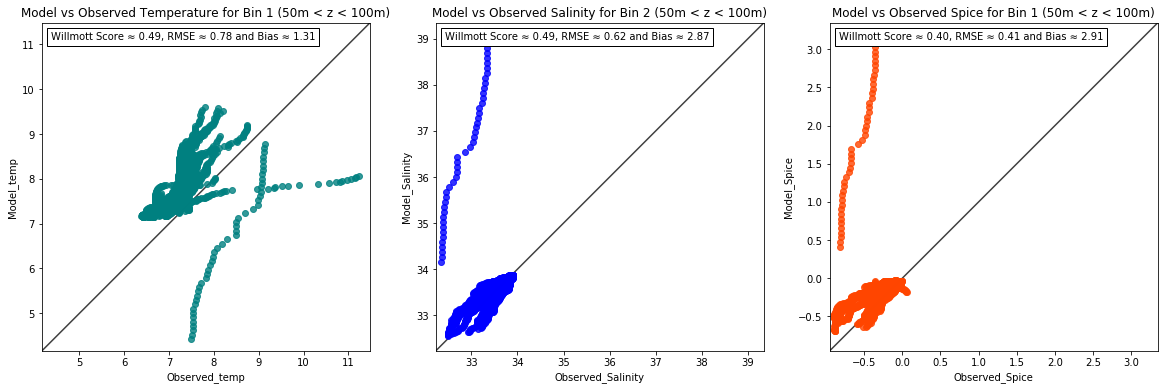

In [163]:
plot_stat_bin_2(obs_temp=tem_bin_2, model_temp=tem_bin_2_m, obs_sal=sal_bin_2, model_sal= sal_bin_2_m, \
          obs_spice= spic_bin_2, model_spice= spic_bin_2_m, z_data= z_bin_2)

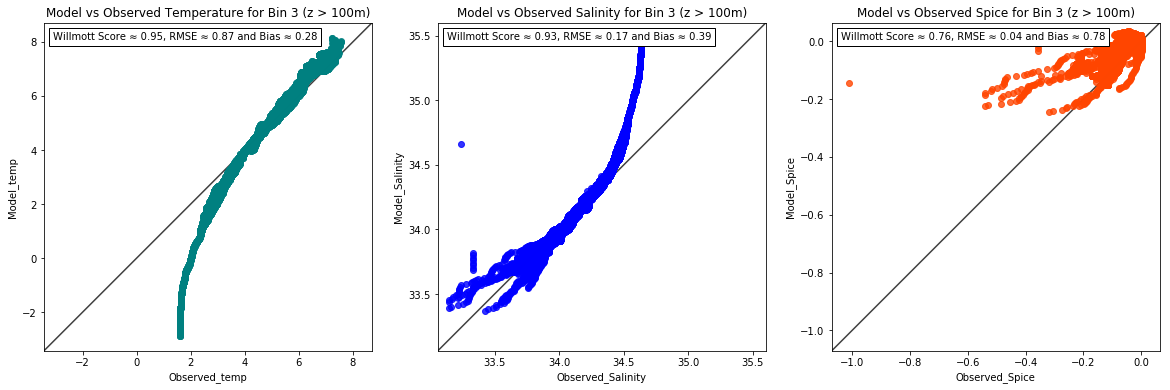

In [164]:
plot_stat_bin_3(obs_temp=tem_bin_3, model_temp=tem_bin_3_m, obs_sal=sal_bin_3, model_sal= sal_bin_3_m, \
          obs_spice= spic_bin_3, model_spice= spic_bin_3_m, z_data= z_bin_3)

In [94]:
z_a = z_a[~z_a.mask]

In [96]:
np.array(z_a)

array([   0.99156817,    1.98314116,    2.97471896,    3.96630158,
          4.95788902,    5.94948127,    6.94107834,    7.93268023,
          8.92428693,    9.91589845,   10.90751479,   11.89913594,
         12.89076191,   13.8823927 ,   14.87402831,   15.86566873,
         16.85731398,   17.84896404,   18.84061892,   19.83227862,
         20.82394313,   21.81561247,   22.80728662,   23.7989656 ,
         24.79064939,   25.782338  ,   26.77403143,   27.76572969,
         28.75743276,   29.74914065,   30.74085336,   31.73257089,
         32.72429325,   33.71602042,   34.70775241,   35.69948923,
         36.69123086,   37.68297732,   38.6747286 ,   39.6664847 ,
         40.65824562,   41.65001136,   42.64178193,   43.63355732,
         44.62533753,   45.61712256,   46.60891241,   47.60070709,
         48.59250659,   49.58431091,   50.57612006,   51.56793403,
         52.55975282,   53.55157644,   54.54340488,   55.53523814,
         56.52707623,   57.51891914,   58.51076688,   59.50261

In [74]:
zlevels.shape

(32,)

In [146]:
j = n[23]
i = m[23]
t = time_location[23]

temp_model = temp[t,:mbathy[j,i],j,i]
xxx = temp_model[np.nonzero(temp_model)]

In [149]:
temp_model

array([ 14.20641804,  13.64383698,  13.15037823,  12.94843578,
        12.78422165,  12.66473293,  12.53901005,  12.42774487,
        12.26917648,  12.16601849,  11.98970413,  11.9142065 ,
        11.61143494,  11.25860596,   0.        ], dtype=float32)

In [143]:
zlevels[:mbathy[j,i]].shape

(15,)

In [144]:
temp_model.shape

(15,)

In [126]:
time_location

array([131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
       132, 133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 135, 135,
       135, 136, 137, 138, 138, 138, 138, 139, 139, 139, 139, 139, 142])

In [103]:
np.max(mbathy)

32

In [88]:
np.max(tem_bin_2_m)

9.6014781255948733